In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import  pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import scipy
import os
from sklearn.decomposition import PCA
import shap

#from ucimlrepo import fetch_ucirepo

import warnings
warnings.filterwarnings('ignore')

#from mappings import *
from functs import *

/home/xannadoo/miniconda3/envs/AFAEexam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Constants

In [2]:
seed = 0
np.random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)

In [3]:
# from_begin=True to not include information from the first and second semester
# nationality=Fals to not include nationality column - there are few international students and there is another column for being international

DOWNLOAD = False
from_begin=True
nationality=False

if DOWNLOAD:
    features, features_full, labels = load_data(from_begin=from_begin, nationality=nationality)

    features.to_csv('data/features.csv', index=False)
    features_full.to_csv('data/features_full.csv', index=False)
    labels.to_csv('data/labels.csv', index=False)

else:
    features = pd.read_csv('data/features.csv')
    features_full = pd.read_csv('data/features_full.csv')
    labels = pd.read_csv('data/labels.csv')

Focus on information knowable before the student joins.

Infomation on curriculum, tuition fees up to date etc dropped as they come later.

In [4]:
features_full.head(10)

marital_status                application_mode  application_order  \
0         single    2nd_phase_general_contingent                  5   
1         single  international_student_bachelor                  1   
2         single    1st_phase_general_contingent                  5   
3         single    2nd_phase_general_contingent                  2   
4        married               over_23_years_old                  1   
5        married               over_23_years_old                  1   
6         single    1st_phase_general_contingent                  1   
7         single    3rd_phase_general_contingent                  4   
8         single    1st_phase_general_contingent                  3   
9         single    1st_phase_general_contingent                  1   

                            course  daytime/evening_attendance  \
0  animation_and_multimedia_design                           1   
1                          tourism                           1   
2             communication_design                           1   
3     journalism_and_communication                           1   
4                   social_service                           0   
5                       management                           0   
6                          nursing                           1   
7                          tourism                           1   
8                   social_service                           1   
9                   social_service                           1   

  previous_qualification  previous_qualification_grade mothers_qualification  \
0        upper_secondary                         122.0       upper_secondary   
1        upper_secondary                         160.0       upper_secondary   
2        upper_secondary                         122.0                 basic   
3        upper_secondary                         122.0                 basic   
4        upper_secondary                         100.0                 basic   
5        upper_secondary                         133.1                 basic   
6        upper_secondary                         142.0       upper_secondary   
7        upper_secondary                         119.0                 basic   
8        upper_secondary                         137.0       upper_secondary   
9        upper_secondary                         138.0       upper_secondary   

  fathers_qualification mothers_occupation  ... displaced  \
0       upper_secondary          unskilled  ...         1   
1      higher_education            skilled  ...         1   
2                 basic          unskilled  ...         1   
3                 basic          unskilled  ...         1   
4                 basic          unskilled  ...         0   
5                 basic          unskilled  ...         0   
6                 basic            skilled  ...         1   
7                 basic          unskilled  ...         1   
8       upper_secondary          unskilled  ...         0   
9       upper_secondary            skilled  ...         1   

   educational_special_needs  gender  scholarship_holder  age_at_enrollment  \
0                          0       1                   0                 20   
1                          0       1                   0                 19   
2                          0       1                   0                 19   
3                          0       0                   0                 20   
4                          0       0                   0                 45   
5                          0       1                   0                 50   
6                          0       0                   1                 18   
7                          0       1                   0                 22   
8                          0       0                   1                 21   
9                          0       0                   0                 18   

   international  unemployment_rate  inflation_rate   gdp  graduated  

In [5]:
features.head(10)

application_order  daytime/evening_attendance  \
0                  5                           1   
1                  1                           1   
2                  5                           1   
3                  2                           1   
4                  1                           0   
5                  1                           0   
6                  1                           1   
7                  4                           1   
8                  3                           1   
9                  1                           1   

   previous_qualification_grade  admission_grade  displaced  \
0                         122.0            127.3          1   
1                         160.0            142.5          1   
2                         122.0            124.8          1   
3                         122.0            119.6          1   
4                         100.0            141.5          0   
5                         133.1            114.8          0   
6                         142.0            128.4          1   
7                         119.0            113.1          1   
8                         137.0            129.3          0   
9                         138.0            123.0          1   

   educational_special_needs  gender  scholarship_holder  age_at_enrollment  \
0                          0       1                   0                 20   
1                          0       1                   0                 19   
2                          0       1                   0                 19   
3                          0       0                   0                 20   
4                          0       0                   0                 45   
5                          0       1                   0                 50   
6                          0       0                   1                 18   
7                          0       1                   0                 22   
8                          0       0                   1                 21   
9                          0       0                   0                 18   

   international  ...  mothers_occupation_skilled  \
0              0  ...                           0   
1              0  ...                           1   
2              0  ...                           0   
3              0  ...                           0   
4              0  ...                           0   
5              0  ...                           0   
6              0  ...                           1   
7              0  ...                           0   
8              1  ...                           0   
9              0  ...                           1   

   fathers_occupation_managerial  fathers_occupation_other  \
0                              0                         0   
1                              0                         0   
2                              0                         0   
3                              0                         0   
4                              0                         0   
5                              0                         0   
6                              0                         0   
7                              0                         0   
8                              0                         0   
9                              0                         0   

   fathers_occupation_professional  fathers_occupation_skilled  \
0                                0                           0   
1                                0                           1   
2                                0                           0   
3                                0                           1   
4                                0                           0   
5                                0                           1   
6                                1                           0   
7                                0                           0   
8    

In [6]:
features.describe()

application_order  daytime/evening_attendance  \
count        4424.000000                 4424.000000   
mean            1.727848                    0.890823   
std             1.313793                    0.311897   
min             0.000000                    0.000000   
25%             1.000000                    1.000000   
50%             1.000000                    1.000000   
75%             2.000000                    1.000000   
max             9.000000                    1.000000   

       previous_qualification_grade  admission_grade    displaced  \
count                   4424.000000      4424.000000  4424.000000   
mean                     132.613314       126.978119     0.548373   
std                       13.188332        14.482001     0.497711   
min                       95.000000        95.000000     0.000000   
25%                      125.000000       117.900000     0.000000   
50%                      133.100000       126.100000     1.000000   
75%                      140.000000       134.800000     1.000000   
max                      190.000000       190.000000     1.000000   

       educational_special_needs       gender  scholarship_holder  \
count                4424.000000  4424.000000         4424.000000   
mean                    0.011528     0.351718            0.248418   
std                     0.106760     0.477560            0.432144   
min                     0.000000     0.000000            0.000000   
25%                     0.000000     0.000000            0.000000   
50%                     0.000000     0.000000            0.000000   
75%                     0.000000     1.000000            0.000000   
max                     1.000000     1.000000            1.000000   

       age_at_enrollment  international  ...  mothers_occupation_skilled  \
count        4424.000000    4424.000000  ...                 4424.000000   
mean           23.265145       0.024864  ...                    0.352622   
std             7.587816       0.155729  ...                    0.477840   
min            17.000000       0.000000  ...                    0.000000   
25%            19.000000       0.000000  ...                    0.000000   
50%            20.000000       0.000000  ...                    0.000000   
75%            25.000000       0.000000  ...                    1.000000   
max            70.000000       1.000000  ...                    1.000000   

       fathers_occupation_managerial  fathers_occupation_other  \
count                    4424.000000               4424.000000   
mean                        0.031193                  0.047920   
std                         0.173860                  0.213622   
min                         0.000000                  0.000000   
25%                         0.000000                  0.000000   
50%                         0.000000                  0.000000   
75%                         0.000000                  0.000000   
max                         1.000000                  1.000000   

       fathers_occupation_professional  fathers_occupation_skilled  \
count                      4424.000000                 4424.000000   
mean                          0.106465                    0.388110   
std                           0.308466                    0.487375   
min                           0.000000                    0.000000   
25%                           0.000000                    0.000000   
50%                           0.000000                    0.000000   
75%                           0.000000                    1.000000   
max                           1.000000                    1.000000   

       marital_status_divorced  marital_status_facto union  \
count              4424.000000                 4424.000000   
mean                  0.020570                    0.005651   
std                   0.141954                    0.074969   
min                   0.000000                    0.000000   
25%                   0.000000       

## Dataset balance

We have processed the data so either people have graduated on time or they have not. The 'not' includes people who are still enrolled (as we cannot say whether they will graduate or drop out) or have dropped out. This makes a binary classification task. The classes are also pretty balanced.

In [7]:
# Data
rows_graduated = labels.graduated.sum()
rows_not_graduated = len(labels) - rows_graduated
total_rows = len(labels)

print(f"Number of rows graduated is {rows_graduated}, corresponding to {rows_graduated/total_rows:.2%} of the data")
print(f"Number of rows not graduated is {rows_not_graduated}, corresponding to {rows_not_graduated/total_rows:.2%} of the data")

Number of rows graduated is 2209, corresponding to 49.93% of the data
Number of rows not graduated is 2215, corresponding to 50.07% of the data


## Representations bias: higher education institutions with a majority of females are overrepresented

In Portugal, 49% of 25-34 year-old women had a tertiary qualification in 2020 compared to 35% of their male peers.


https://www.oecd-ilibrary.org/sites/db0e552c-en/index.html?itemId=/content/component/db0e552c-en

The higher imbalance ratio in our dataset compared to OECD data could be attributed to the composition of higher education institutions. For instance, programs like Nursing and Veterinary Nursing, which typically enroll a higher number of females, may contribute to this imbalance. Conversely, fields such as Law Enforcement Studies and more technical courses, which tend to attract more males, might not be represented in our dataset, further skewing the gender distribution.

OECD Imbalance Ratio is 1.40
Number of rows male graduates: 548, corresponding to 12.39% of the data
Number of rows female graduates: 1661, corresponding to 37.55% of the data
Dataset Imbalance is 3.03



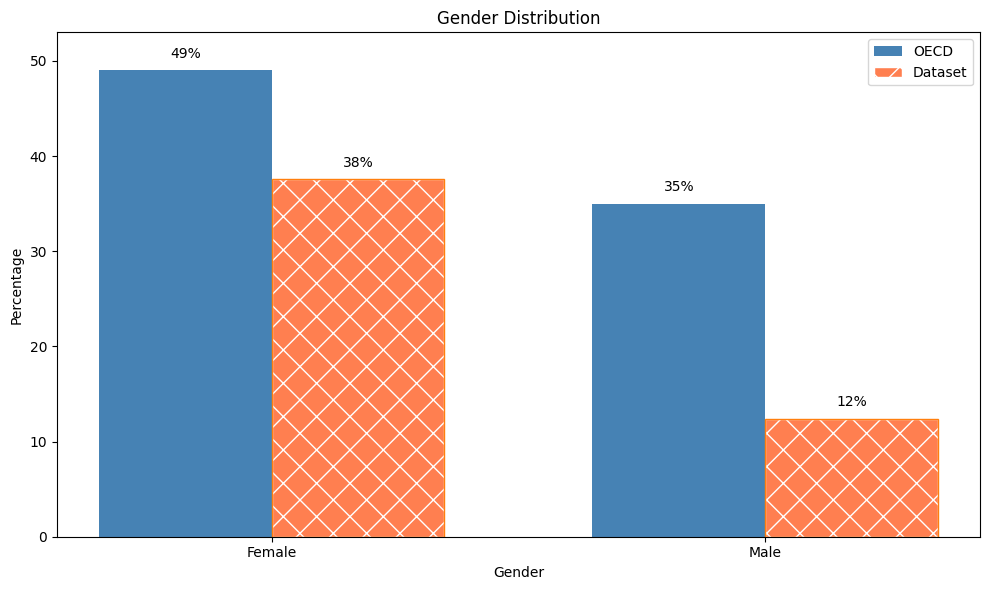

In [8]:
# OECD Data
female_tertiary = 49  # percentage of 25-34 year-old women with tertiary qualification
male_tertiary = 35    # percentage of 25-34 year-old men with tertiary qualification

print(f"OECD Imbalance Ratio is {female_tertiary/male_tertiary:.2f}")

# Data: Calculate percentages
rows_male = len(features[(features.gender == 1) & (labels.graduated == 1)].index)
rows_female = len(features[(features.gender == 0) & (labels.graduated == 1)].index)
total_rows = len(features)

male_percentage = 100 * rows_male / total_rows
female_percentage = 100 * rows_female / total_rows
print(f"Number of rows male graduates: {rows_male}, corresponding to {rows_male/total_rows:.2%} of the data")
print(f"Number of rows female graduates: {rows_female}, corresponding to {rows_female/total_rows:.2%} of the data")
print(f"Dataset Imbalance is {rows_female/rows_male:.2f}\n")

labels_data = ['Male', 'Female']
values_data = [rows_male, rows_female]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

# Bar plot for female tertiary qualification rates
ax.bar(index[0] - bar_width/2, female_tertiary, bar_width, color='steelblue',  label='OECD')
ax.bar(index[0] + bar_width/2, female_percentage, bar_width, color='coral',hatch='X', edgecolor='white',zorder=0, label='Dataset')
ax.bar(index[0] + bar_width/2, female_percentage, bar_width, color='none', edgecolor='tab:orange')

ax.bar(index[1] - bar_width/2, male_tertiary, bar_width, color='steelblue')
ax.bar(index[1] + bar_width/2, male_percentage, bar_width, color='coral',hatch='X', edgecolor='white',zorder=0)
ax.bar(index[1] + bar_width/2, male_percentage, bar_width, color='none', edgecolor='tab:orange')

ax.set_xlabel('Gender')
ax.set_ylabel('Percentage')
ax.set_title('Gender Distribution')
ax.set_xticks(index)
ax.set_xticklabels(['Female', 'Male'])
ax.legend()

# Add text annotations
ax.text(index[0] - bar_width/2, female_tertiary + 1, f'{female_tertiary}%', ha='center', va='bottom')
ax.text(index[1] - bar_width/2, male_tertiary + 1, f'{male_tertiary}%', ha='center', va='bottom')
ax.text(index[0] + bar_width/2, female_percentage + 1, f'{female_percentage:.0f}%', ha='center', va='bottom')
ax.text(index[1] + bar_width/2, male_percentage + 1, f'{male_percentage:.0f}%', ha='center', va='bottom')

plt.ylim(0,53)
plt.tight_layout()


plt.savefig('img/gender_disb_oecd.png', transparent=True)
plt.show()

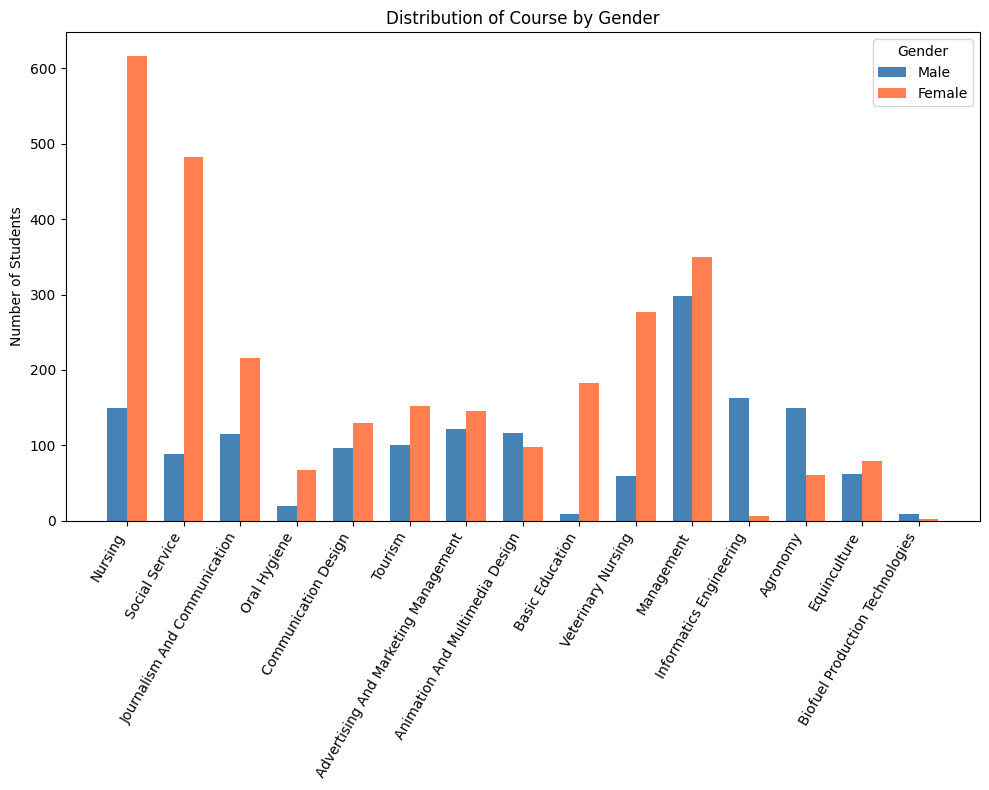

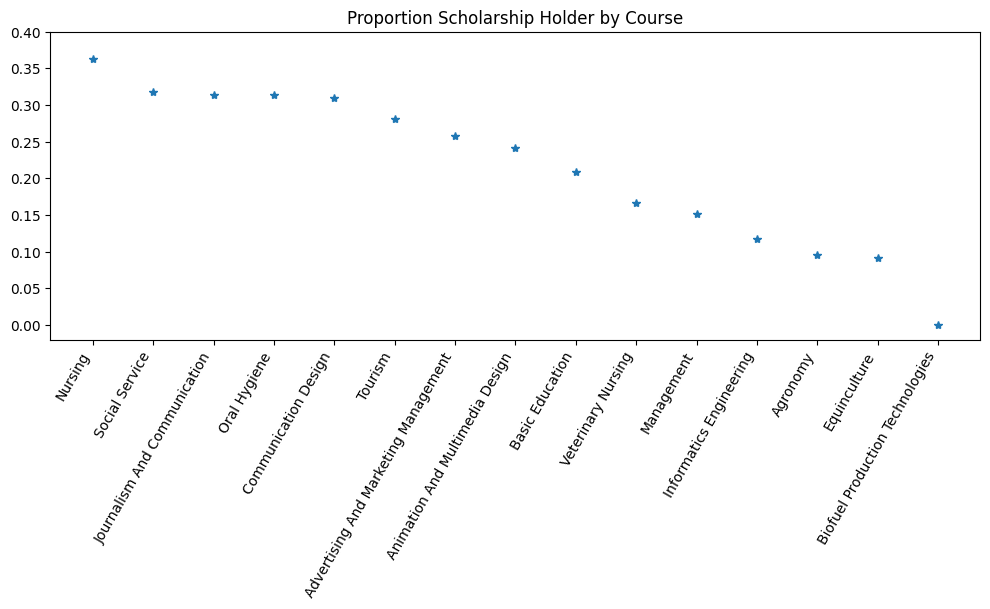

In [9]:
# we had noticed a connection between courses/scholarship holders/gender:

# This sorts features into order from highest scholarship % to lowest
a = features_full[["course", "scholarship_holder"]].groupby('course').mean().reset_index().sort_values(by='scholarship_holder', ascending=False)

c_order = list(a.course)

plot_feature(feature_name='course', 
             features_full=features_full, 
             column_feature='gender',
             order=c_order,
             colors=['coral', 'steelblue'], 
             labels=['Female', 'Male'], 
             show_ratio=False, figsize=(10,8),
             save=True, file_name='course_disp_gender')

_, ax = plt.subplots(1, 1, figsize=(12,4))

ax.plot(a.course, a.scholarship_holder, marker='*', ls='')
ax.set_xticklabels([x.replace('_', ' ').title() for x in a.course], rotation=60, ha='right')
ax.set_ylim(-0.02,0.4)
ax.set_title('Proportion Scholarship Holder by Course');
#We can see that 2 courses with a high proportion of scholarships also have a high proportion of female applicants

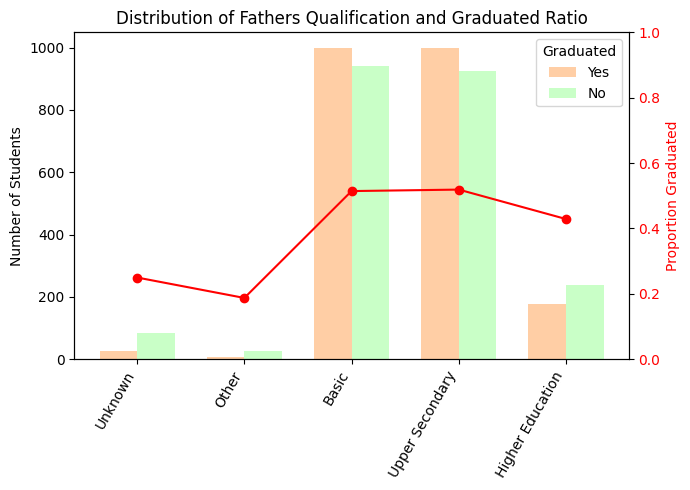

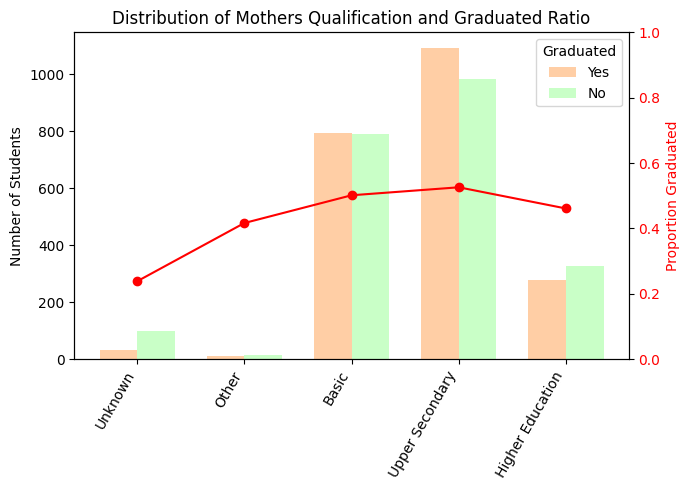

In [10]:
q_order = ['unknown','other','basic','upper_secondary','higher_education',]
plot_feature(feature_name = "fathers_qualification", 
             features_full=features_full, order=q_order,
             save=True, file_name='father_qual_grad')

plot_feature(feature_name = "mothers_qualification", 
             features_full=features_full, order=q_order,
             save=True, file_name='mother_qual_grad')

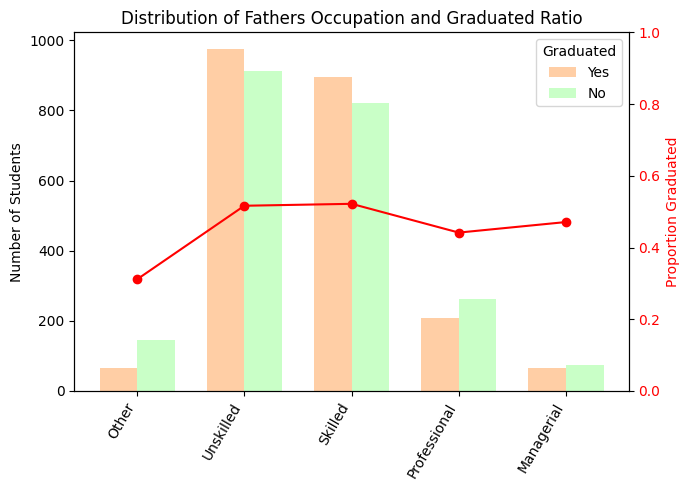

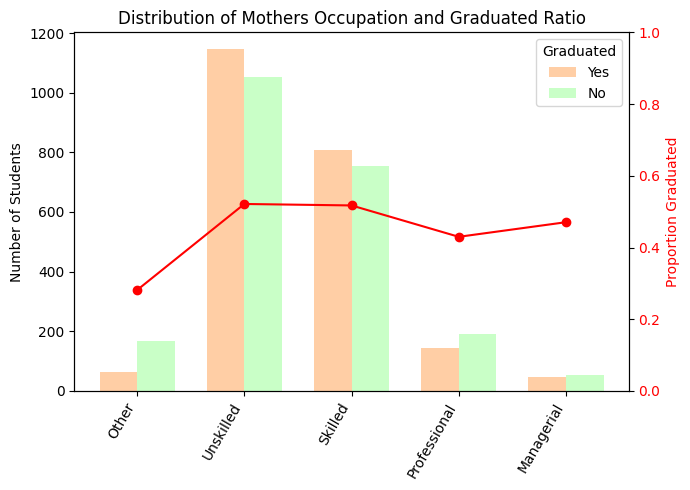

In [11]:
o_order = ['other','unskilled','skilled', 'professional', 'managerial']
plot_feature(feature_name = "fathers_occupation", 
             features_full=features_full, order=o_order,
             save=True, file_name='father_occu_grad')

plot_feature(feature_name = "mothers_occupation", 
             features_full=features_full, order=o_order,
             save=True, file_name='mother_occu_grad')

In [12]:
## order dataset for correllation plotting

df = features.join(labels)

cir = [ 'curricular_units_1st_sem_credited',
 'curricular_units_1st_sem_enrolled',
 'curricular_units_1st_sem_evaluations',
 'curricular_units_1st_sem_approved',
 'curricular_units_1st_sem_grade',
 'curricular_units_1st_sem_without_evaluations',

 'curricular_units_2nd_sem_credited',
 'curricular_units_2nd_sem_enrolled',
 'curricular_units_2nd_sem_evaluations',
 'curricular_units_2nd_sem_approved',
 'curricular_units_2nd_sem_grade',
 'curricular_units_2nd_sem_without_evaluations',]

main_feats = [
 'application_mode_1st_phase_special_contingent_azores_island',
 'application_mode_1st_phase_special_contingent_madeira_island',
 'application_mode_2nd_phase_general_contingent',
 'application_mode_3rd_phase_general_contingent',
 'application_mode_change_of_course',
 'application_mode_change_of_institution_course',
 'application_mode_change_of_institution_course_international',
 'application_mode_holders_of_other_higher_courses',
 'application_mode_international_student_bachelor',
 'application_mode_ordinance_no_533A_99_item_b2_different_plan',
 'application_mode_ordinance_no_533A_99_item_b3_other_institution',
 'application_mode_ordinance_no_612_93',
 'application_mode_ordinance_no_854B_99',
 'application_mode_over_23_years_old',
 'application_mode_short_cycle_diploma_holders',
 'application_mode_technological_specialization_diploma_holders',
 'application_mode_transfer',
 'application_order',
 'course_advertising_and_marketing_management',
 'course_agronomy',
 'course_animation_and_multimedia_design',
 'course_basic_education',
 'course_biofuel_production_technologies',
 'course_communication_design',
 'course_equinculture',
 'course_informatics_engineering',
 'course_journalism_and_communication',
 'course_management',
 'course_oral_hygiene',
 'course_social_service',
 'course_tourism',
 'course_veterinary_nursing',
 'previous_qualification_basic',
 'previous_qualification_higher_education',
 'previous_qualification_other',
 'daytime/evening_attendance',
 'previous_qualification_grade',
 'admission_grade',
 
 'unemployment_rate',
 'inflation_rate',
 'gdp',

 'mothers_qualification_basic',
 'mothers_qualification_higher_education',
 'mothers_qualification_other',
 'mothers_qualification_unknown',
 'fathers_qualification_basic',
 'fathers_qualification_higher_education',
 'fathers_qualification_other',
 'fathers_qualification_unknown',
 'mothers_occupation_managerial',
 'mothers_occupation_other',
 'mothers_occupation_professional',
 'mothers_occupation_skilled',
 'fathers_occupation_managerial',
 'fathers_occupation_other',
 'fathers_occupation_professional',
 'fathers_occupation_skilled',
 
 'scholarship_holder',

 'displaced',
 'educational_special_needs',
 'marital_status_divorced',
 'marital_status_facto union',
 'marital_status_legally separated',
 'marital_status_married',
 'marital_status_widower',
 'age_at_enrollment',
 'international',
 'gender',
 'graduated']

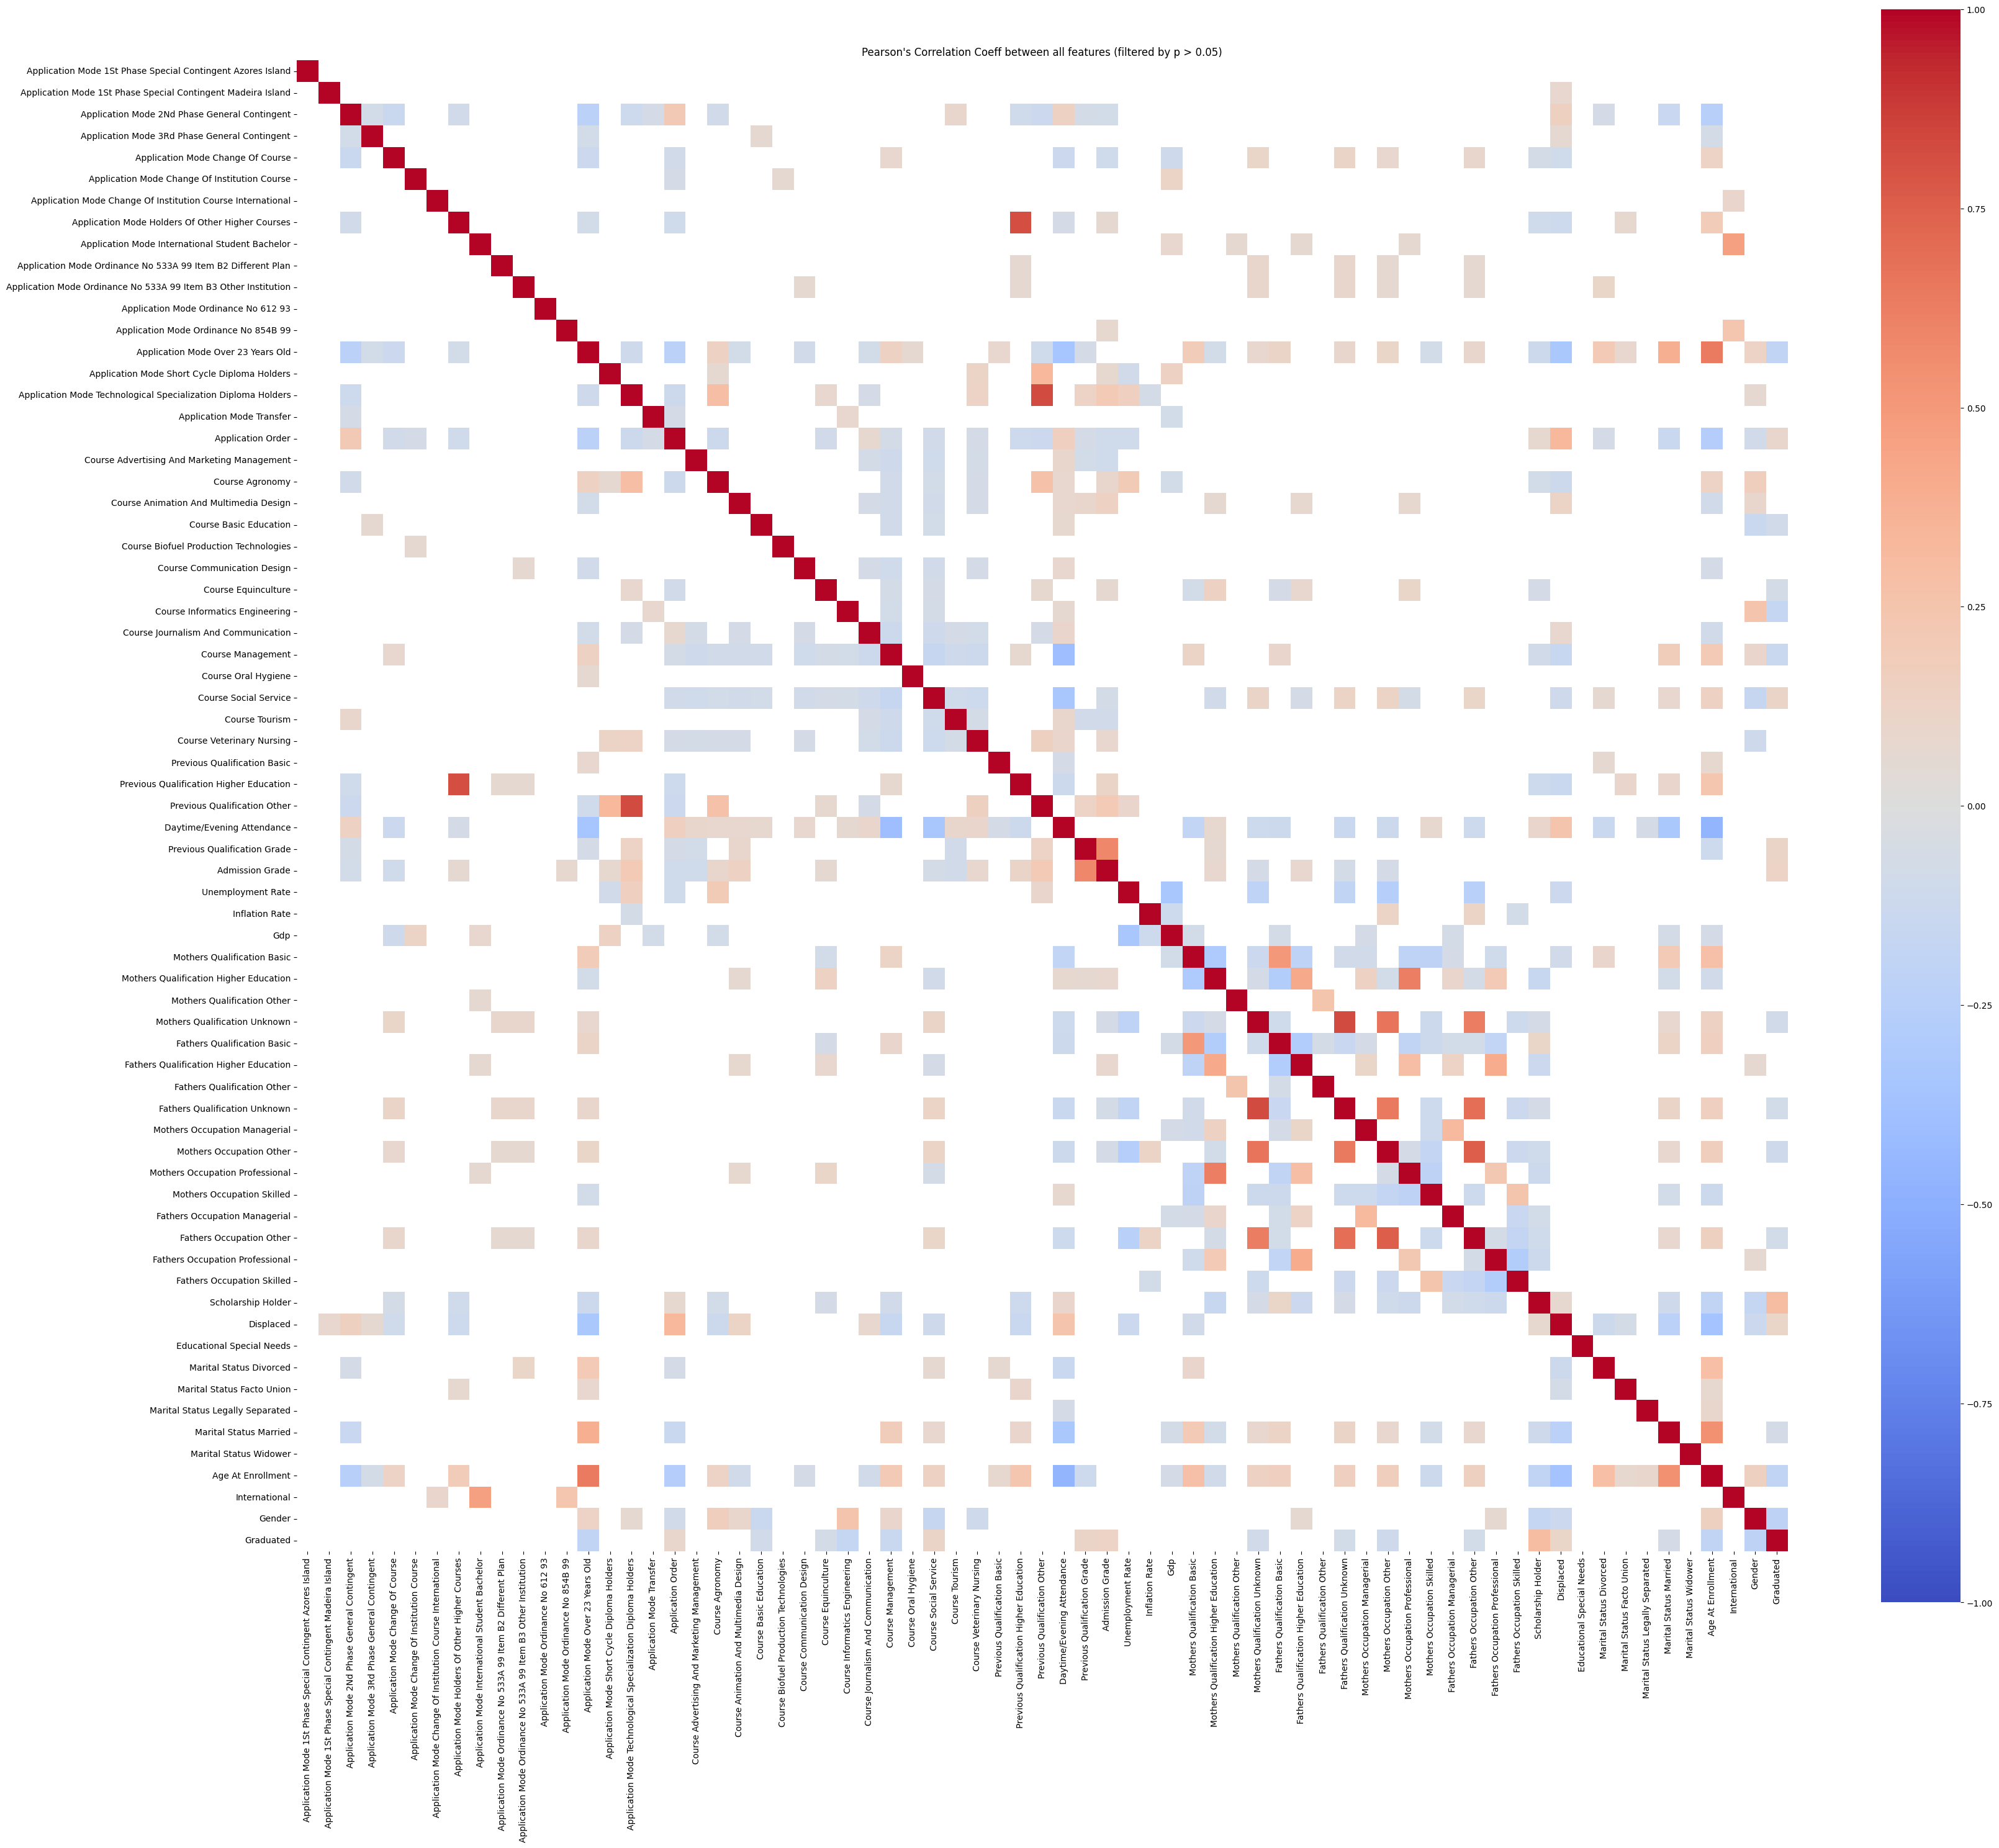

In [13]:
## columns arranged into sections:
# 1st semester info
# 2nd semester info 
# course info
# macro socioeconomic factors
# personal socioeconomic factors
# demographic info
# graduated

if from_begin:
    df = df[main_feats]
else:
    df = df[cir + main_feats]

_, ax = plt.subplots(1,1, figsize=(35,30),)
plot_corr(df=df,  show_specific_features=False,ax=ax)

plt.savefig('img/full_corr.png', transparent=True)

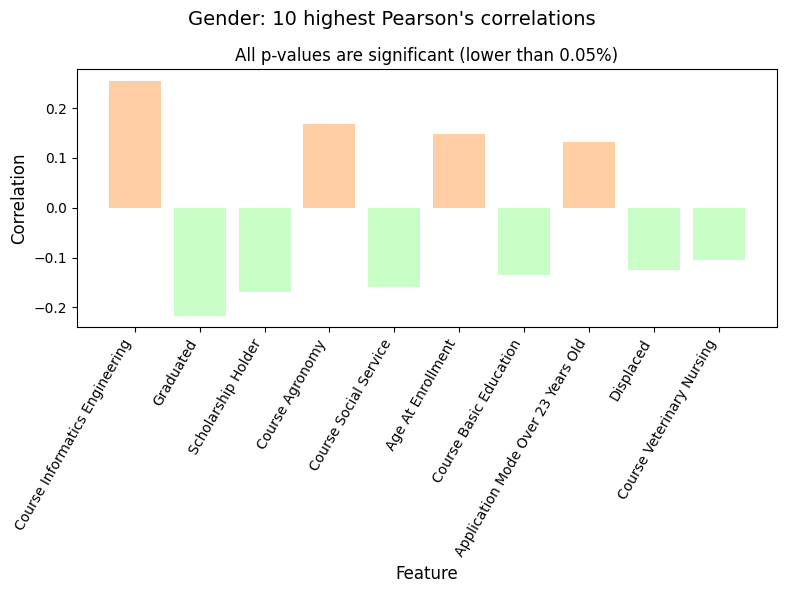

In [14]:
_, ax = plt.subplots(1,1, figsize=(8,6))
plot_corr(df,feature_cols=['gender'], show_specific_features=True, num_corr=10, ax=ax)

plt.savefig('img/gender_10_corr.png', transparent=True)


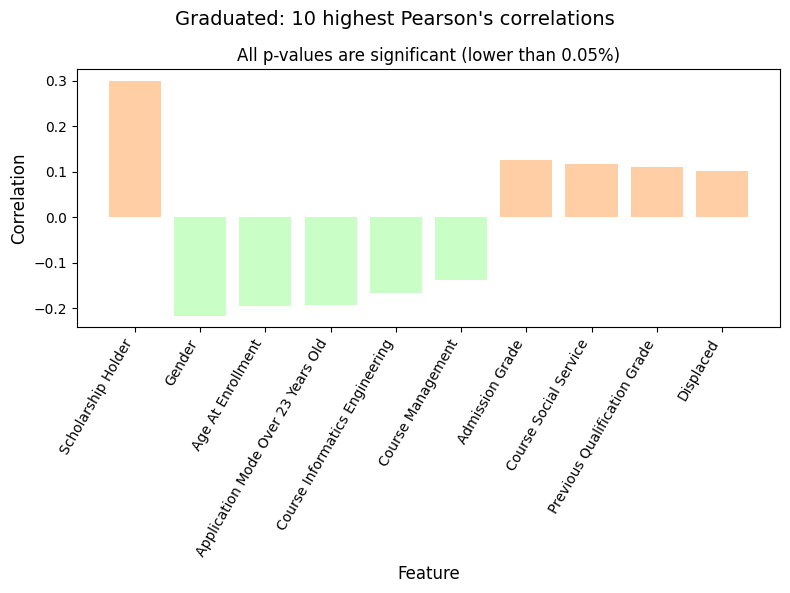

In [15]:
_, ax = plt.subplots(1,1, figsize=(8,6))
plot_corr(df=df,feature_cols=['graduated'], show_specific_features=True, num_corr=10, ax=ax)

plt.savefig('img/grad_pear_10_corr.png', transparent=True)

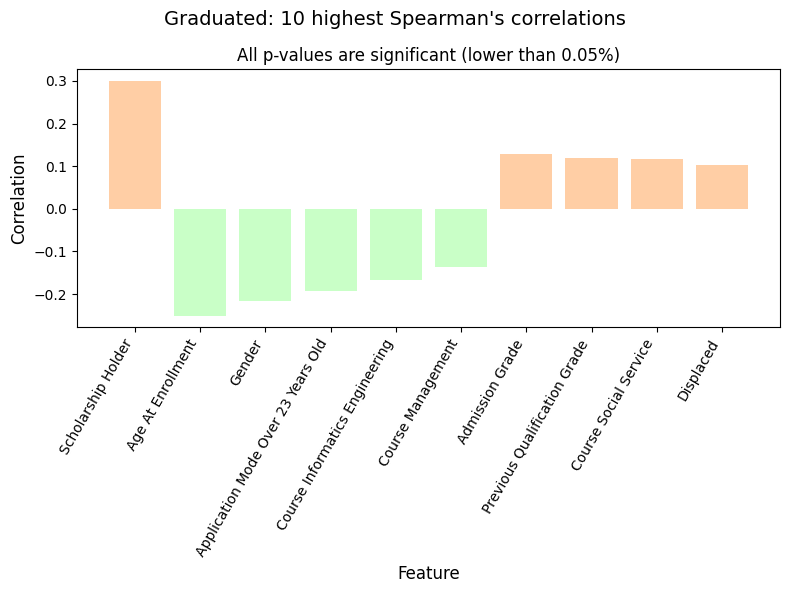

In [16]:
_, ax = plt.subplots(1,1, figsize=(8,6))
plot_corr(df=df,feature_cols=['graduated'], show_specific_features=True, method="spearman", num_corr=10, ax=ax)
plt.savefig('img/grad_spear_10_corr.png', transparent=True)

# Baseline Model

In [17]:
## protected columns: cannot discriminate against certain attributes
protected_cols_demographic = [x for x in df.columns if (x in ['educational_special_needs',
                                                                    'displaced',
                                                                    'age_at_enrollment',
                                                                     'international',
                                                                    'gender',]) or ('marital_status' in x)]

## add likely proxies for socio-economic data as well
protected_cols_demographic_and_socio_economic = [x for x in df.columns if ('mother' in x) or ('father' in  x) or (x in protected_cols_demographic) \
                                                                 or x in ['scholarship_holder']   ]


## Focused on these groups to avoid too many plots when comparing protected columns. Scholarship status and gender showed a relatively high correlation with graduation likelihood.
## Furthermore, did parents' background seems to have a little influence as well.

group_cols_demographic=[x for x in features.columns if (x in ['educational_special_needs',
                                                                    'displaced',
                                                                     'international',
                                                                    'gender',]) or ('marital_status' in x)]
groups_demographic = features[group_cols_demographic]

group_cols_demographic_and_socio_economic=[x for x in features.columns if ('scholarship_holder' in x) or ('mother' in x) or ('father' in  x) or (x in ['educational_special_needs',
                                                                    'displaced',
                                                                     'international',
                                                                    'gender',]) or ('marital_status' in x)]
groups_demographic_and_socio_economic = features[group_cols_demographic_and_socio_economic]



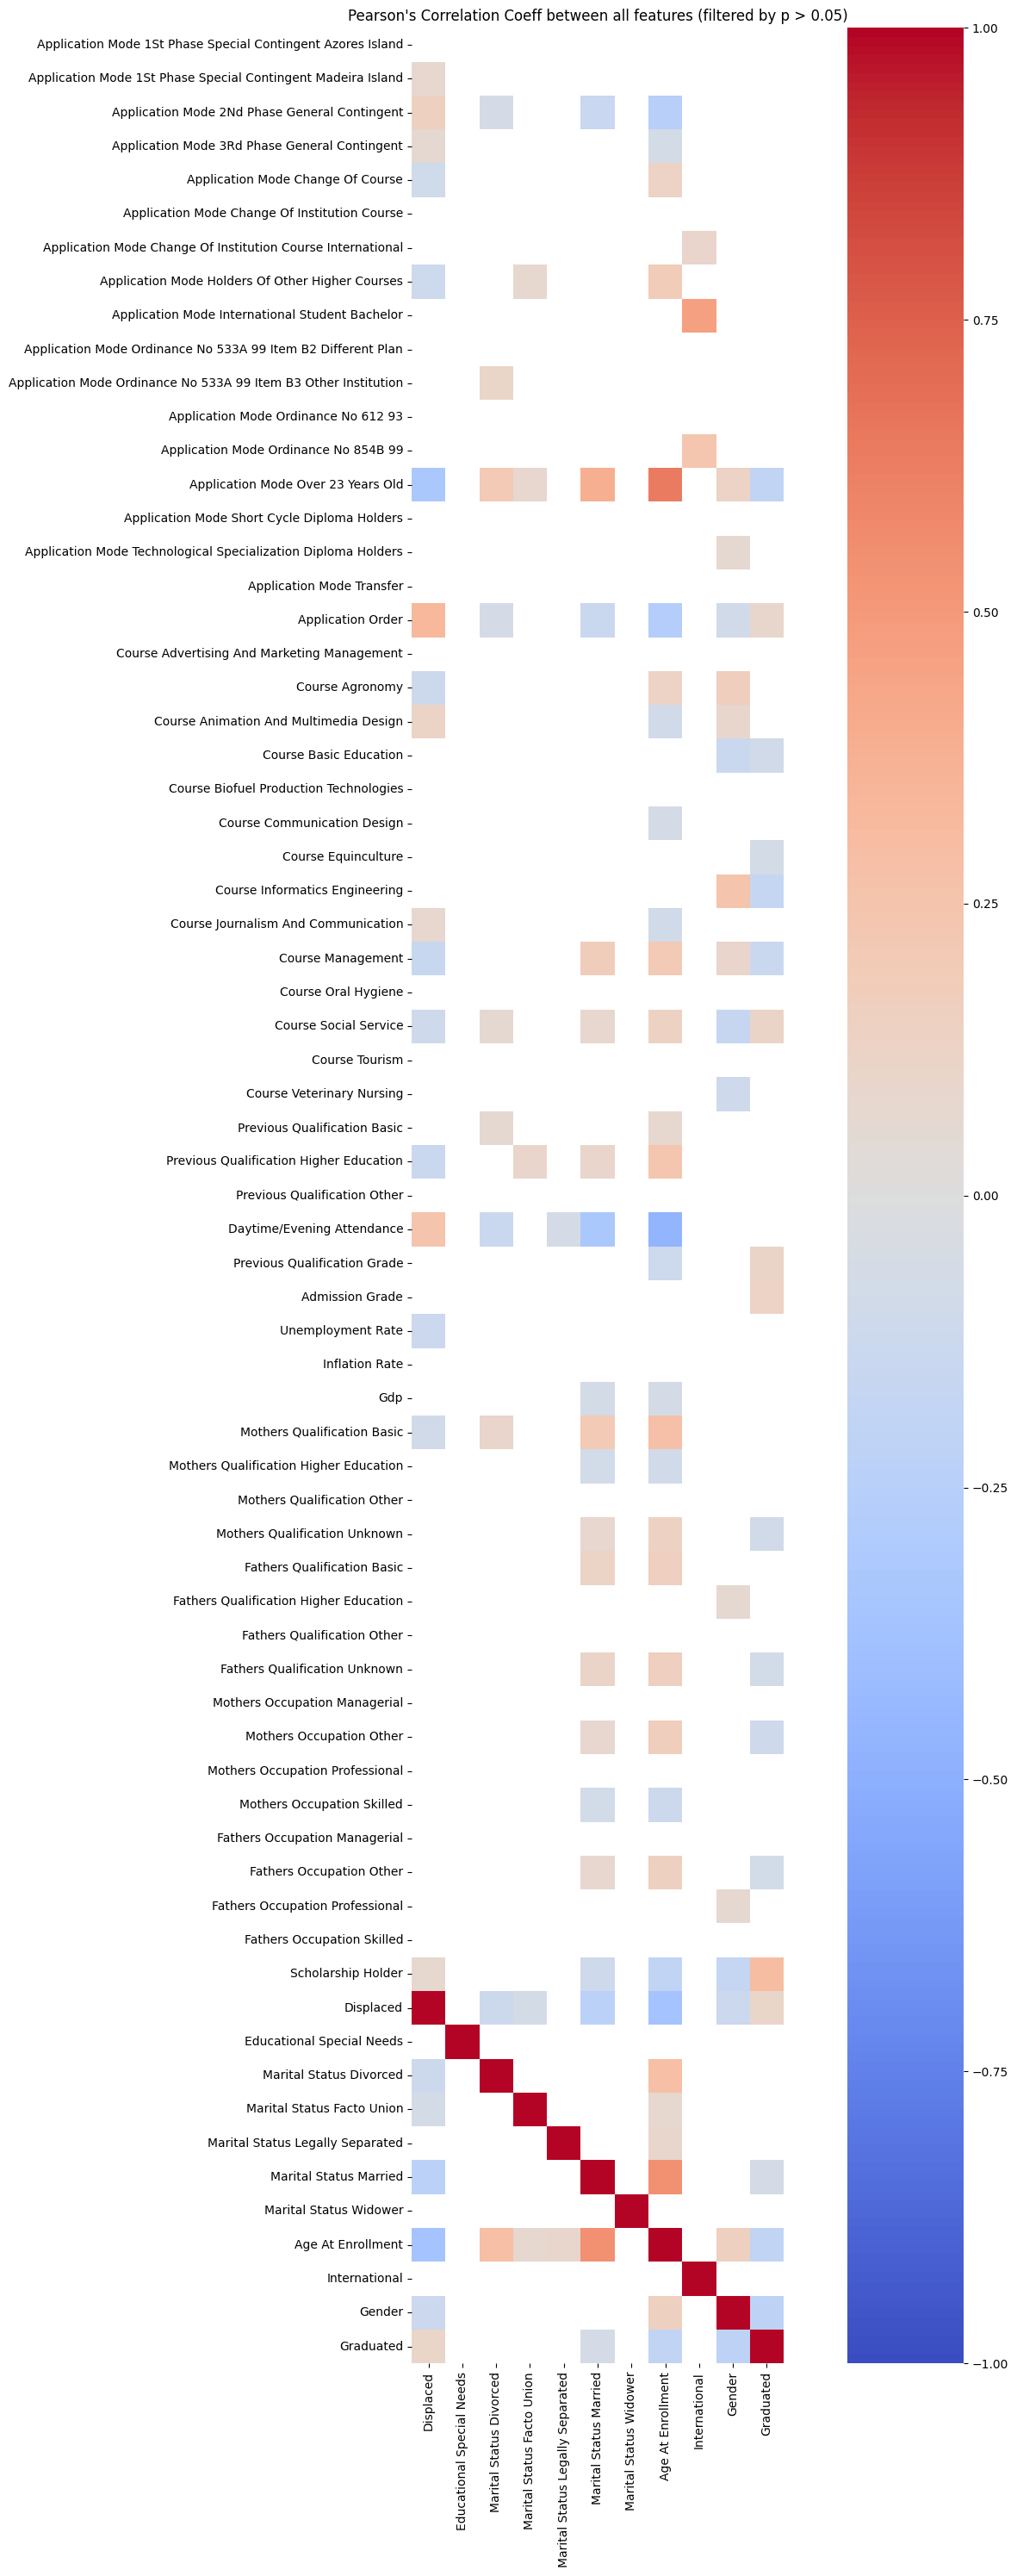

In [18]:
_, ax = plt.subplots(1,1, figsize=(15,30))
plot_corr(df=df,feature_cols=protected_cols_demographic+['graduated'],ax=ax, show_specific_features=True)
plt.savefig('img/protected_pear_corr.png', transparent=True)


## Base model: 
Logistic regression, logististic regression with fair pca (lambda=0)

In [19]:
logreg = LogisticRegression(max_iter=1000, random_state=seed)

In [20]:
logreg_preds = cross_validator(logreg, features, labels)

print("Base model\nclassification report:\n",classification_report(labels, logreg_preds))

print('*'*50)

## Geometric
logreg_preds_db_demographic = cross_validator(model=logreg, X=features, y=labels, protected_cols=protected_cols_demographic, debias='geometric')

print("Geometric Debias (demographic)\nclassification report:\n",classification_report(labels, logreg_preds_db_demographic))

print('*'*50)

logreg_preds_db_demographic_and_socio_economic = cross_validator(model=logreg, X=features, y=labels, protected_cols=protected_cols_demographic_and_socio_economic, debias='geometric')

print("Geometric Debias (demographic and socio-economic)\nclassification report:\n",classification_report(labels, logreg_preds_db_demographic_and_socio_economic))

print('*'*50)


## FairPCA
logreg_preds_pca_demographic = cross_validator(model=logreg, X=features, y=labels, protected_cols=protected_cols_demographic, debias='fairPCA')

print("FairPCA debias (demographic)\nclassification report:\n",classification_report(labels, logreg_preds_pca_demographic))

logreg_preds_pca_demographic_and_socio_economic = cross_validator(model=logreg, X=features, y=labels, protected_cols=protected_cols_demographic_and_socio_economic, debias='fairPCA')

print("FairPCA debias (demographic and socio-economic)\nclassification report:\n",classification_report(labels, logreg_preds_pca_demographic_and_socio_economic))



Base model
classification report:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70      2215
           1       0.70      0.70      0.70      2209

    accuracy                           0.70      4424
   macro avg       0.70      0.70      0.70      4424
weighted avg       0.70      0.70      0.70      4424

**************************************************
Geometric Debias (demographic)
classification report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70      2215
           1       0.70      0.69      0.69      2209

    accuracy                           0.70      4424
   macro avg       0.70      0.70      0.70      4424
weighted avg       0.70      0.70      0.70      4424

**************************************************
Geometric Debias (demographic and socio-economic)
classification report:
               precision    recall  f1-score   support

           0       0.68  

### Remove protected features entirely

1. Focussed:
+ remove demographic data

2. Strict:
+ remove demographic and socio-economic data

In [21]:
# filter columns containing protected features
unrestricted = [x for x in features.columns if x not in protected_cols_demographic]

unrestricted_2 = [x for x in unrestricted if (x not in protected_cols_demographic_and_socio_economic)]

In [22]:
features_unres = features[unrestricted].copy()
features_unres_2 = features[unrestricted_2].copy()

logreg_preds_unres = cross_validator(logreg, features_unres, labels)
logreg_preds_unres_2 = cross_validator(logreg, features_unres_2, labels)

print("Unrestricted model (demographic)\nclassification report:\n",classification_report(labels, logreg_preds_unres))

print('*'*50)

print("Unrestricted (strict) model (demographic and socio-economic)\nclassification report:\n",classification_report(labels, logreg_preds_unres_2))


Unrestricted model (demographic)
classification report:
               precision    recall  f1-score   support

           0       0.70      0.70      0.70      2215
           1       0.70      0.70      0.70      2209

    accuracy                           0.70      4424
   macro avg       0.70      0.70      0.70      4424
weighted avg       0.70      0.70      0.70      4424

**************************************************
Unrestricted (strict) model (demographic and socio-economic)
classification report:
               precision    recall  f1-score   support

           0       0.68      0.65      0.66      2215
           1       0.66      0.70      0.68      2209

    accuracy                           0.67      4424
   macro avg       0.67      0.67      0.67      4424
weighted avg       0.67      0.67      0.67      4424



## Fairness comparison

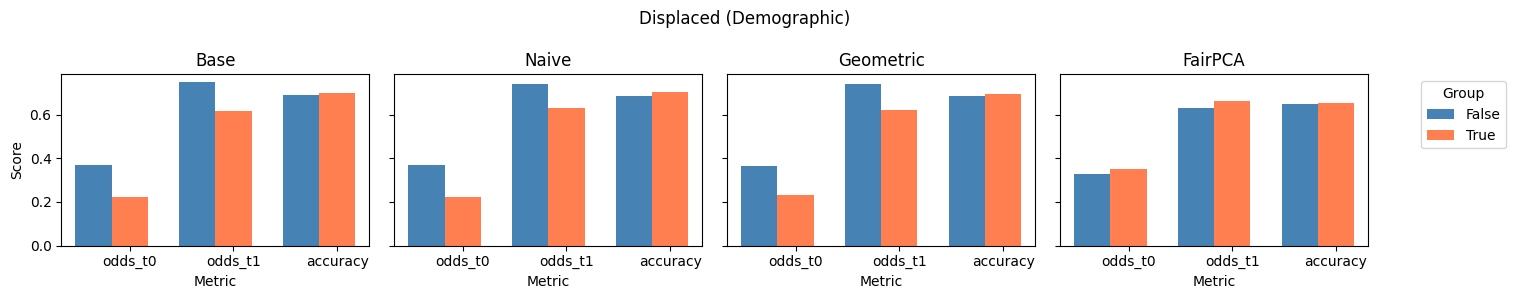

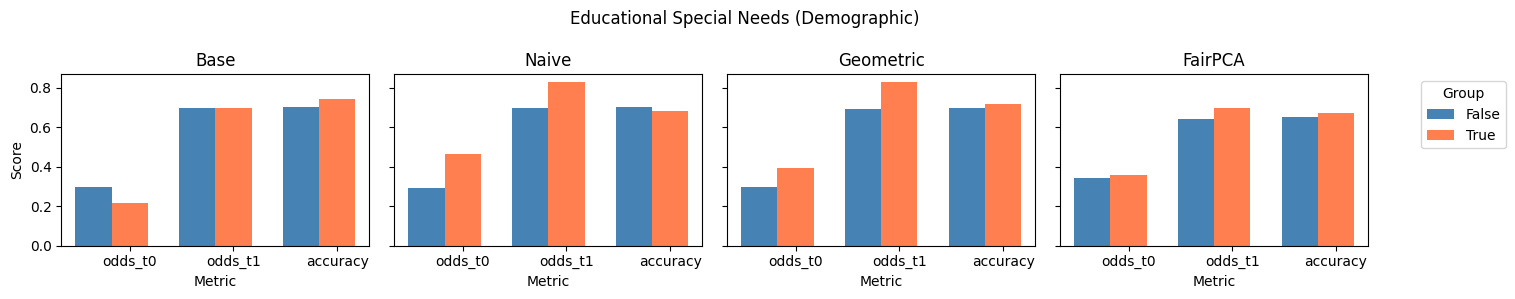

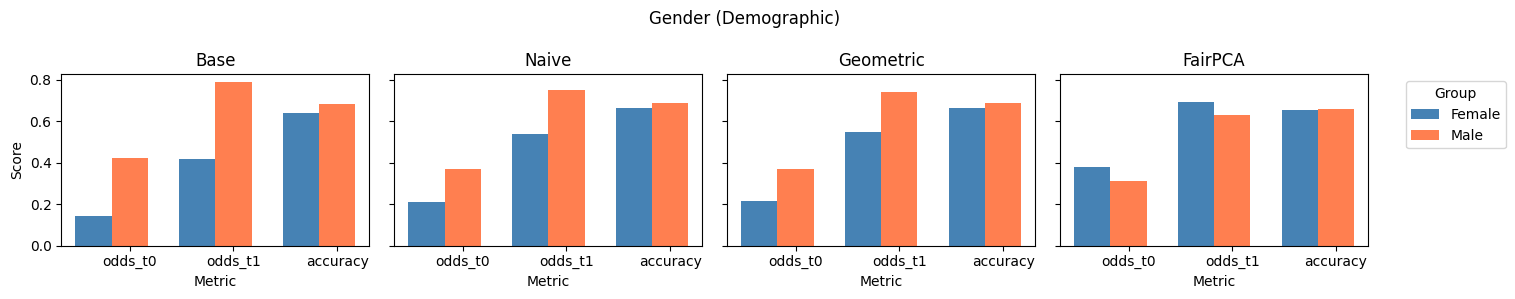

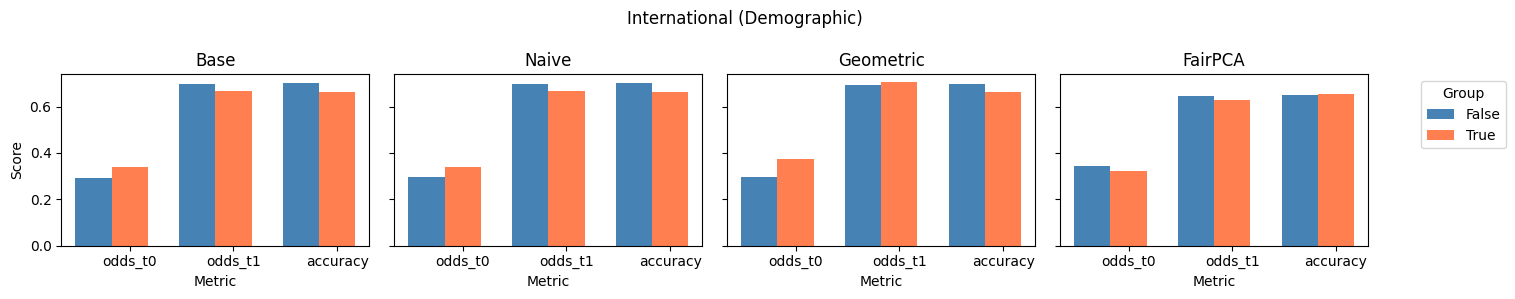

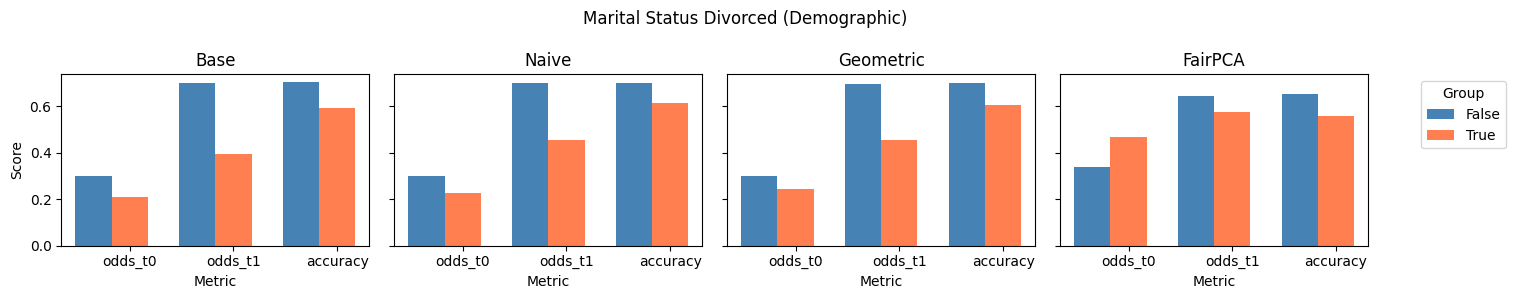

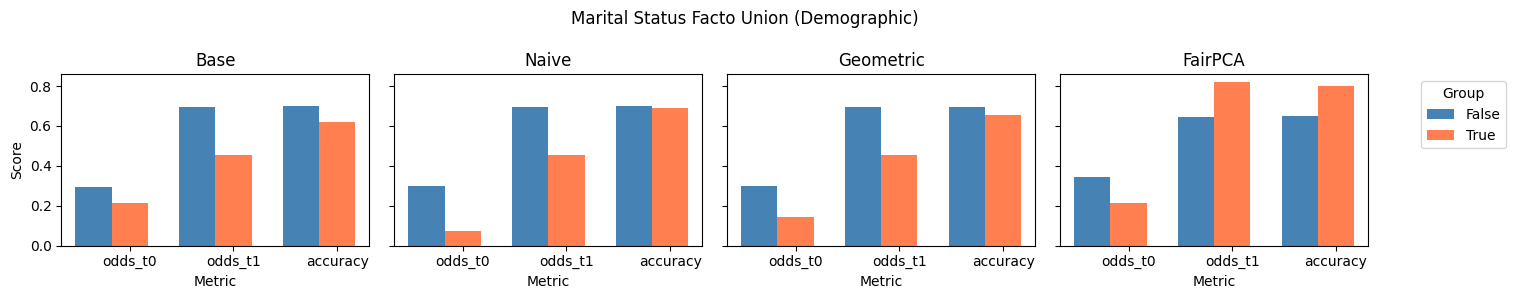

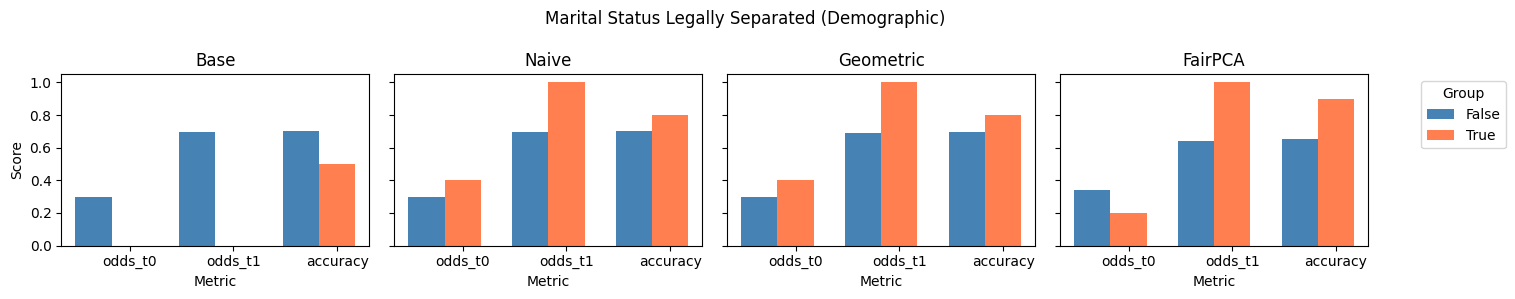

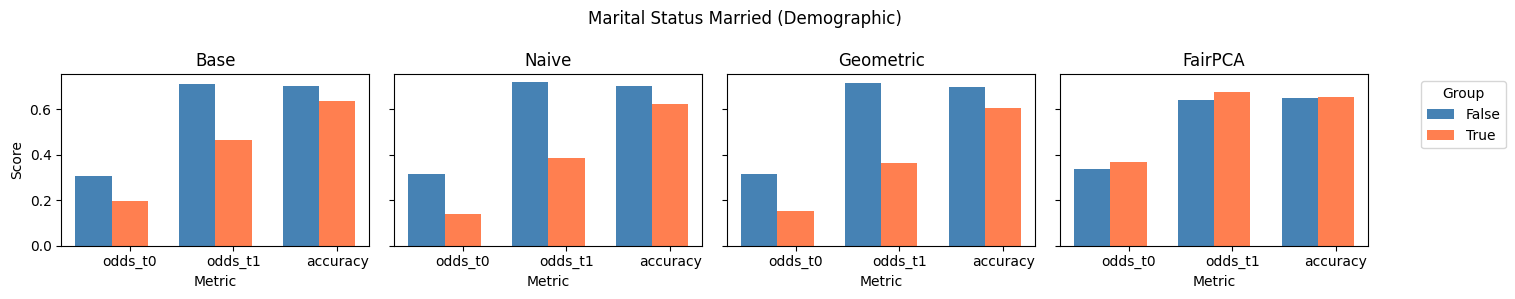

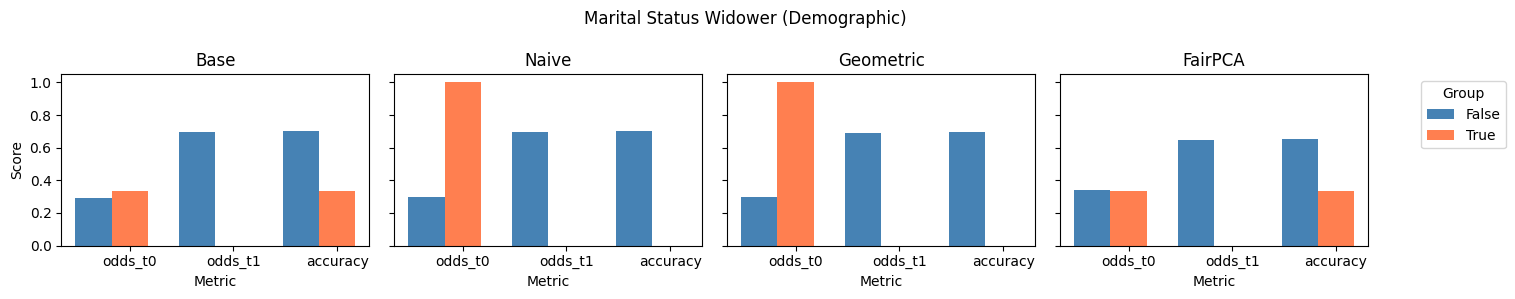

In [23]:
### remove demographic data
for g in groups_demographic:
    if g=='gender':
        gn = ['Female', 'Male']
    else:
        gn = ['False', 'True']

    log_metric_score = metric_scores(y_test=labels, y_pred = logreg_preds, group_test=groups_demographic[g])
    log_metric_df = metric_df(log_metric_score, group_names=gn, names=metric_names)

    log_metric_score_geom_demographic = metric_scores(y_test=labels, y_pred = logreg_preds_db_demographic, group_test=groups_demographic[g])
    log_metric_df_geom_demographic = metric_df(log_metric_score_geom_demographic, group_names=gn, names=metric_names)

    log_metric_score_pca_demographic = metric_scores(y_test=labels, y_pred = logreg_preds_pca_demographic, group_test=groups_demographic[g])
    log_metric_df_pca_demographic = metric_df(log_metric_score_pca_demographic, group_names=gn, names=metric_names)
        
    log_metric_score_1 = metric_scores(y_test=labels, y_pred = logreg_preds_unres, group_test=groups_demographic[g])
    log_metric_df_1 = metric_df(log_metric_score_1, group_names=gn, names=metric_names)

    plot_scores_and_group_compare([log_metric_df,log_metric_df_1, log_metric_df_geom_demographic, log_metric_df_pca_demographic], 
                                  titles=['Base', 'Naive','Geometric', 'FairPCA'],
                                  suptitle=f'{g.replace("_", " ").title()} (Demographic)', 
                                  color_palette=['steelblue', 'coral'], 
                                  figsize=(15,3))

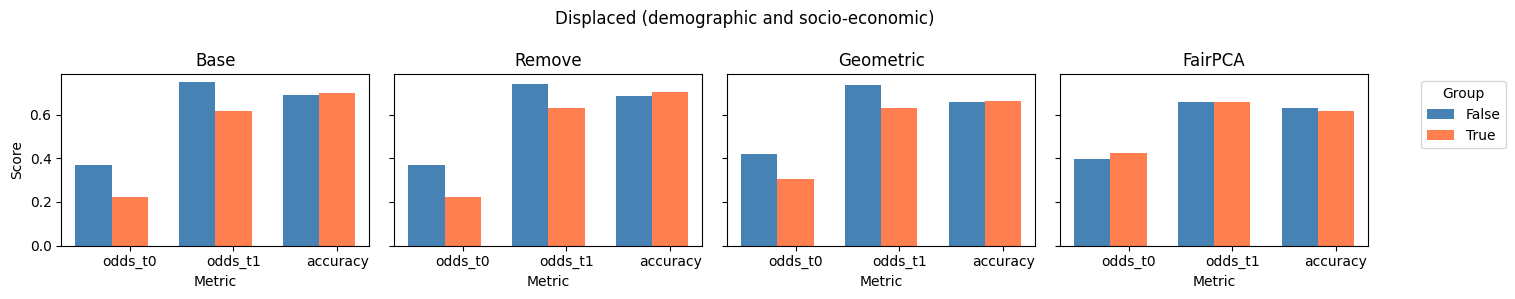

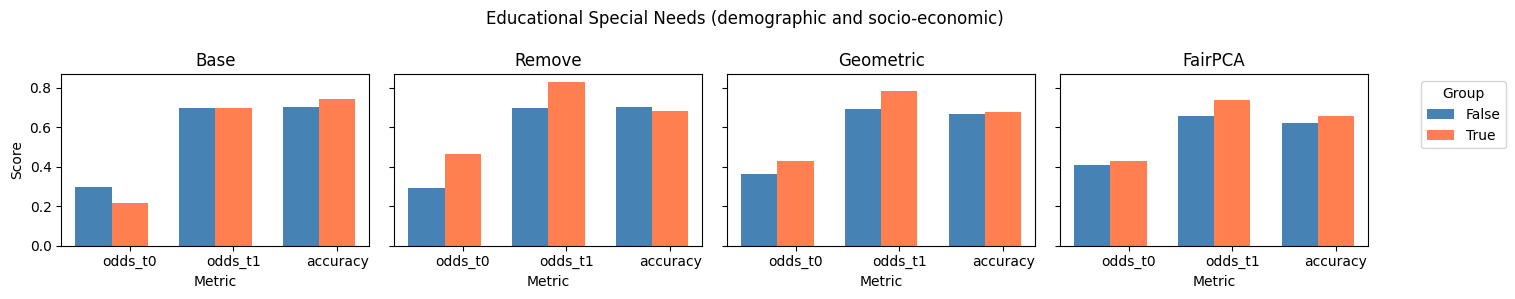

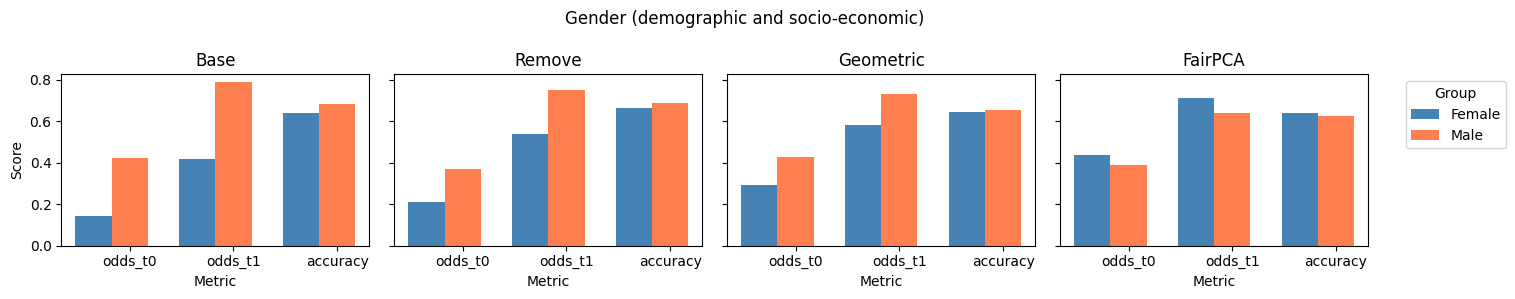

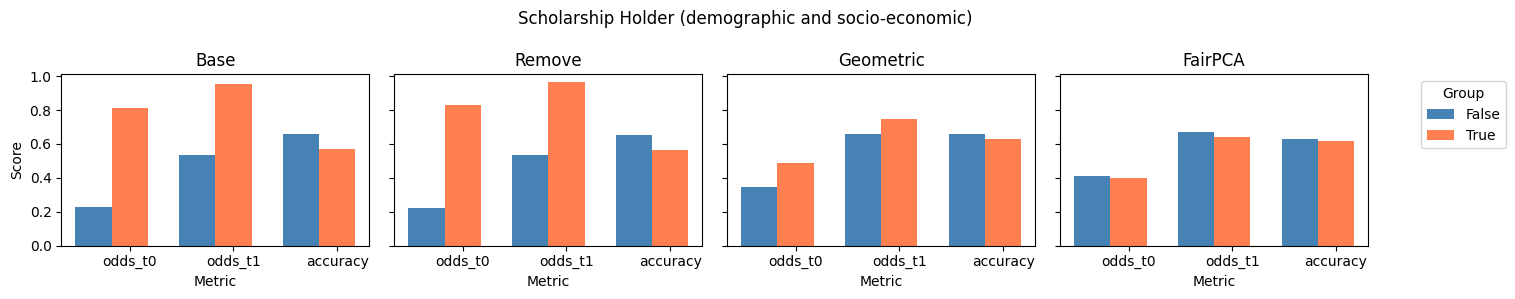

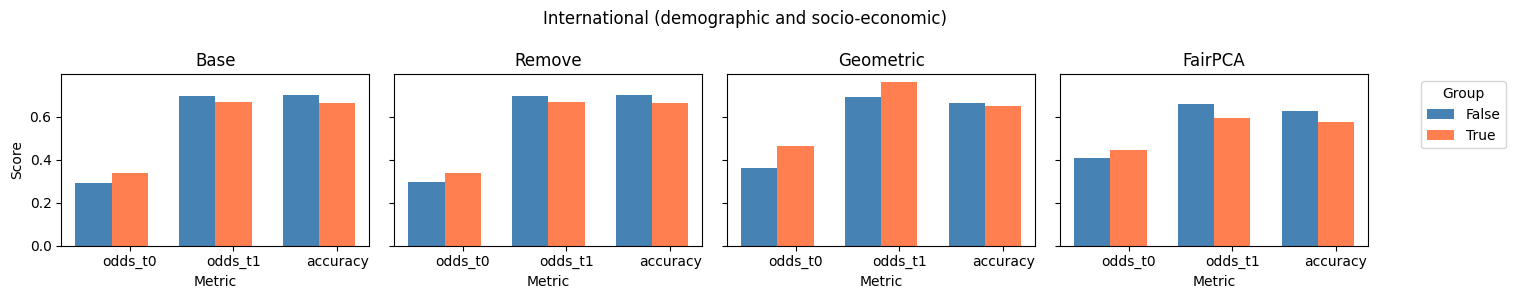

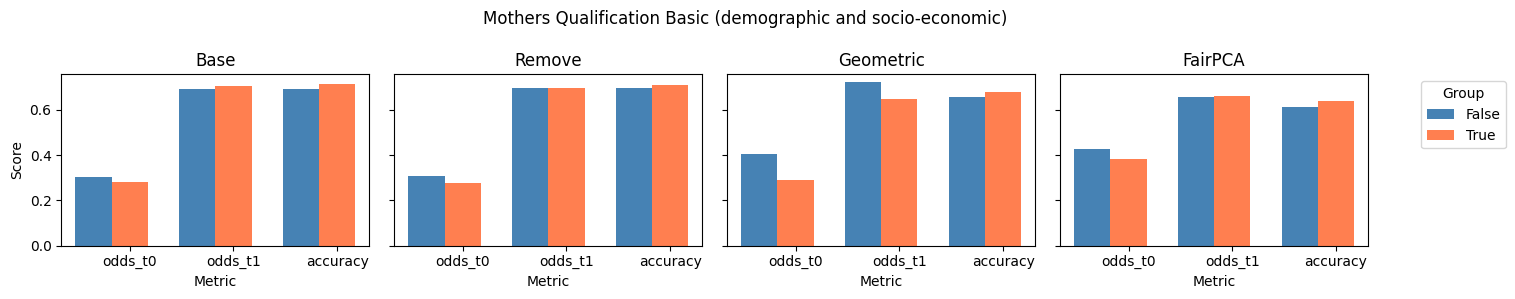

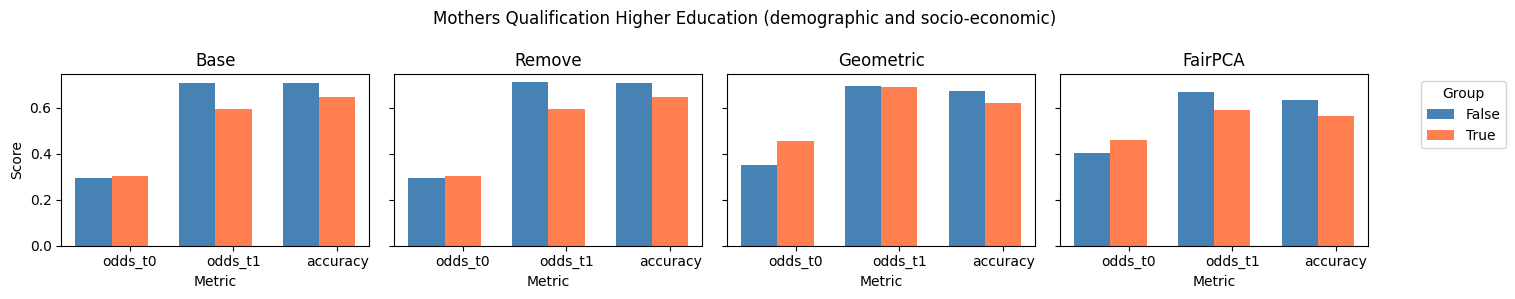

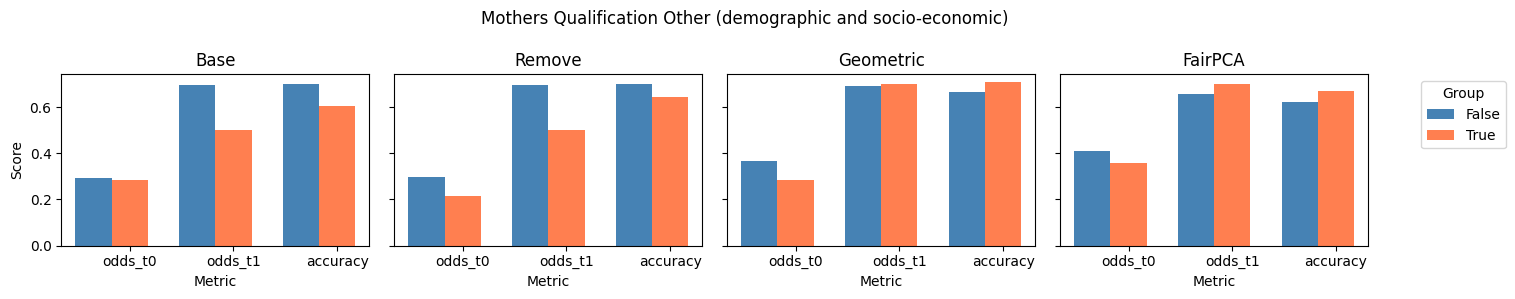

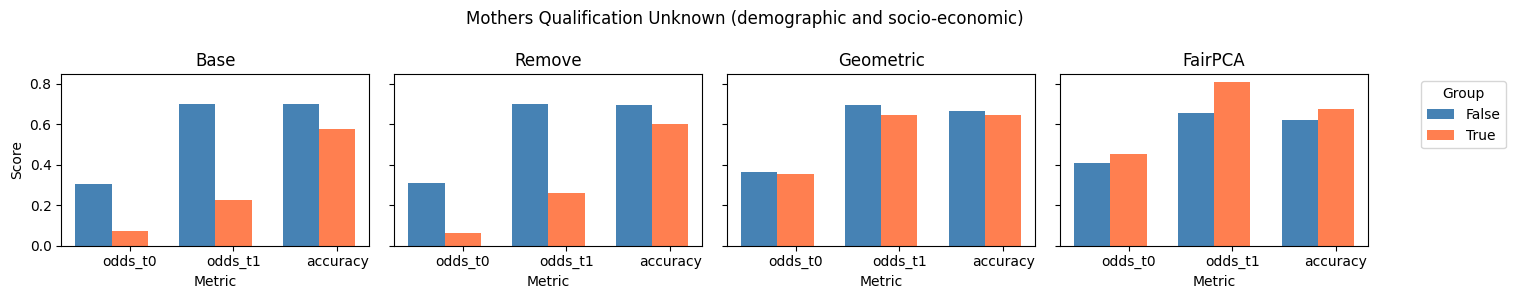

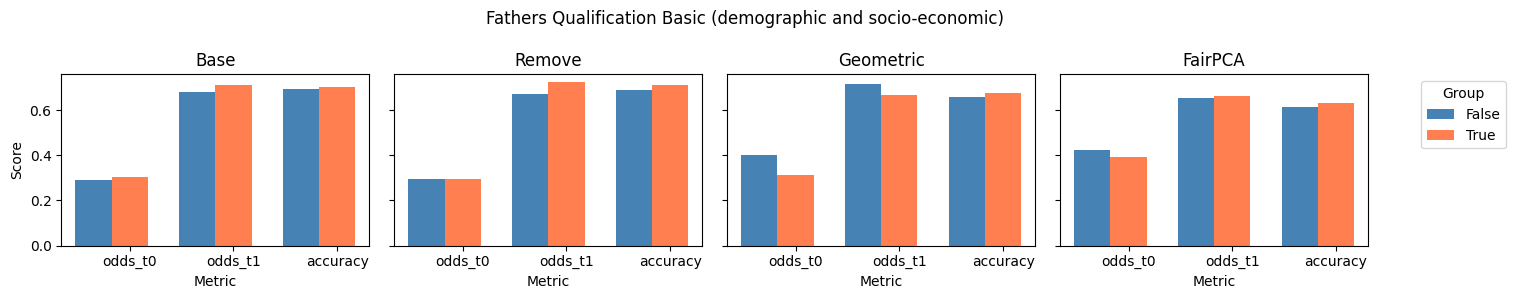

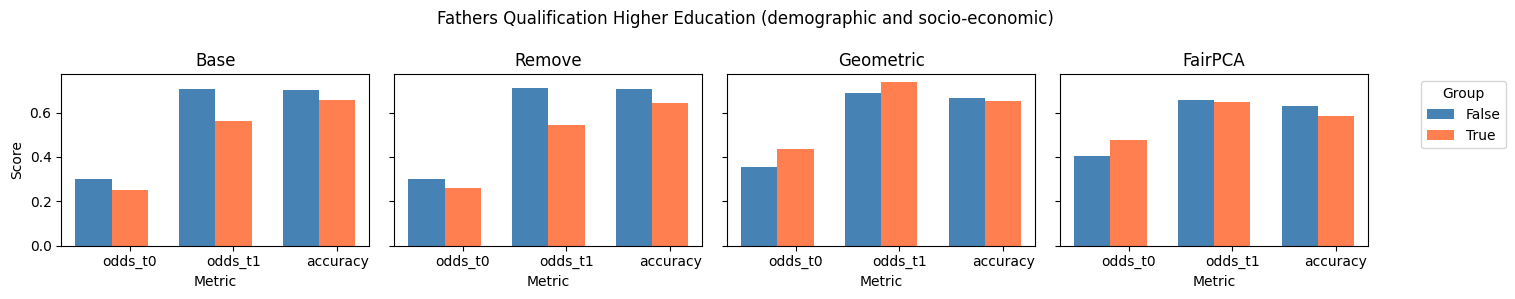

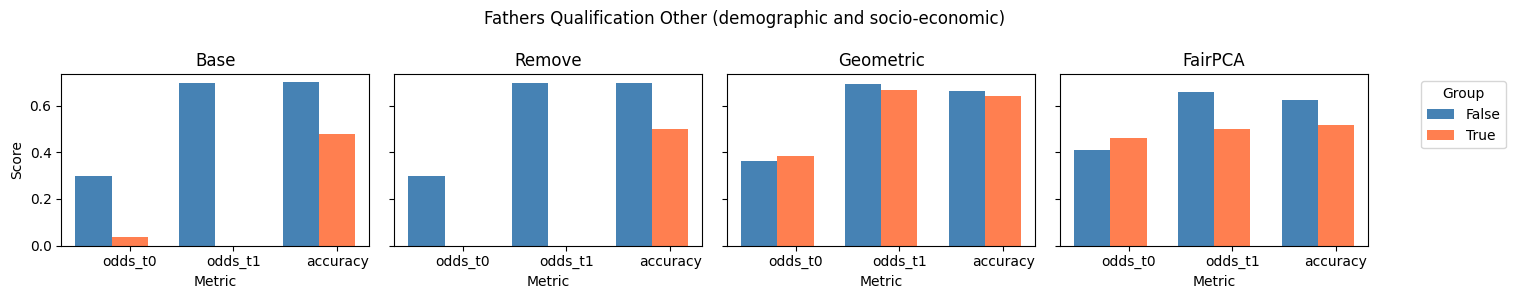

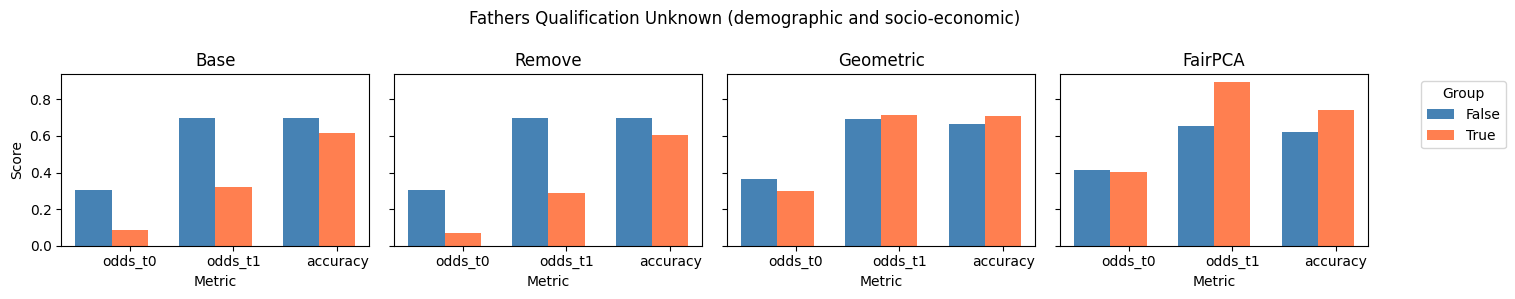

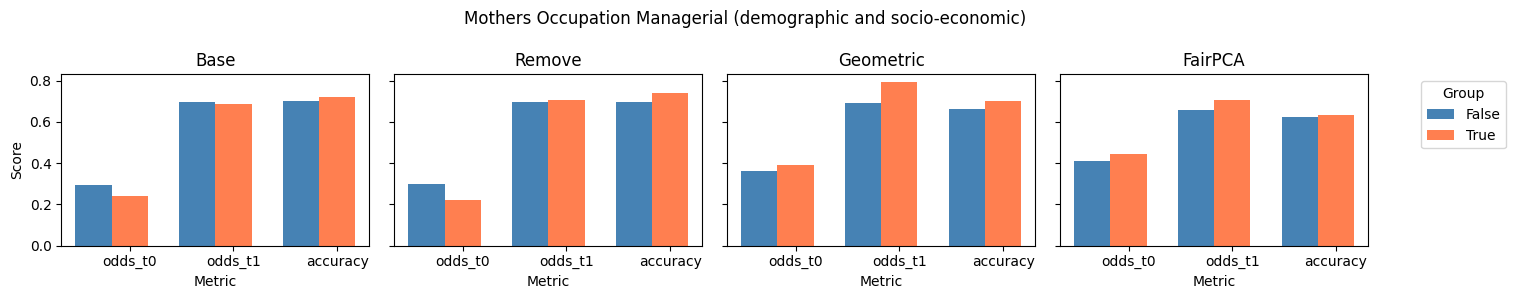

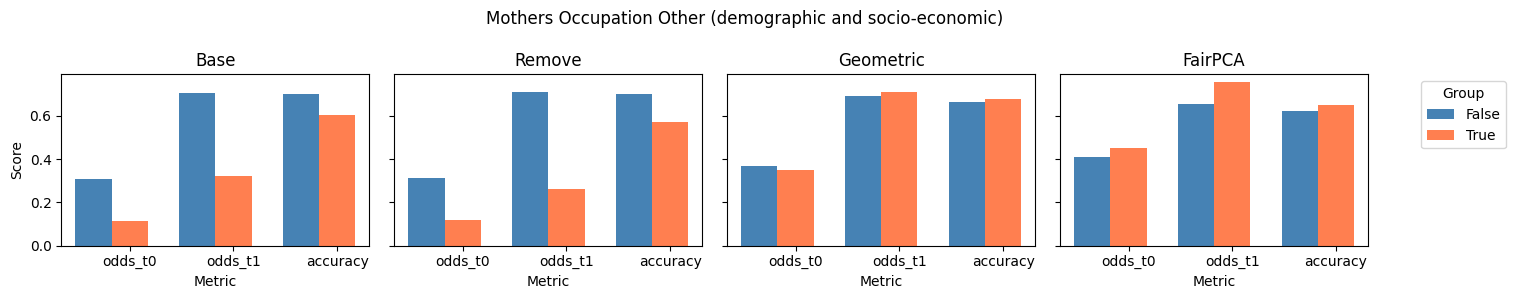

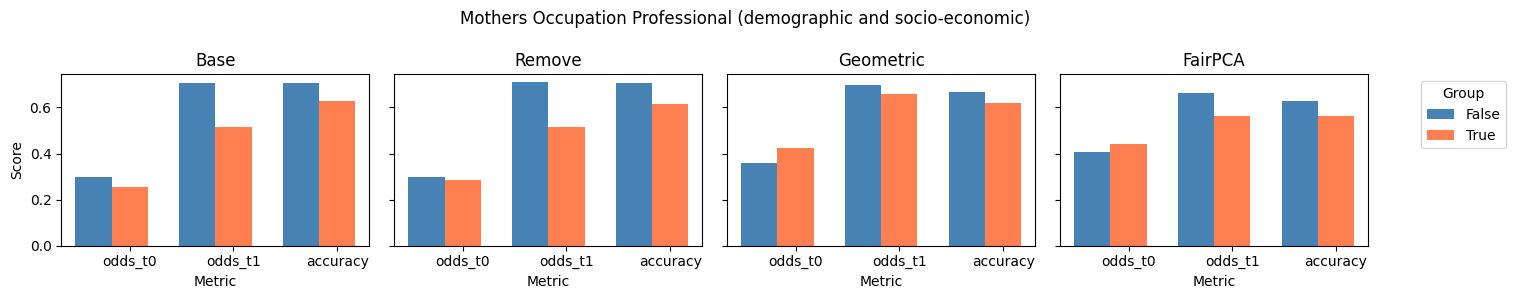

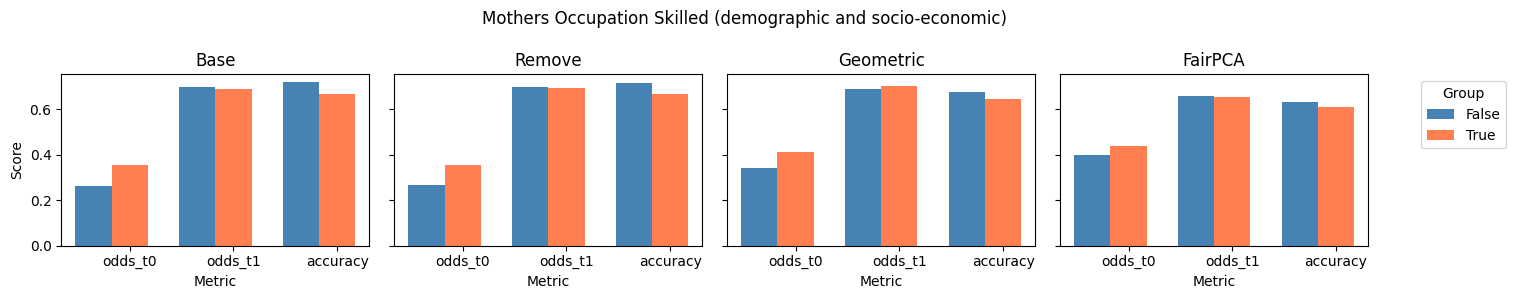

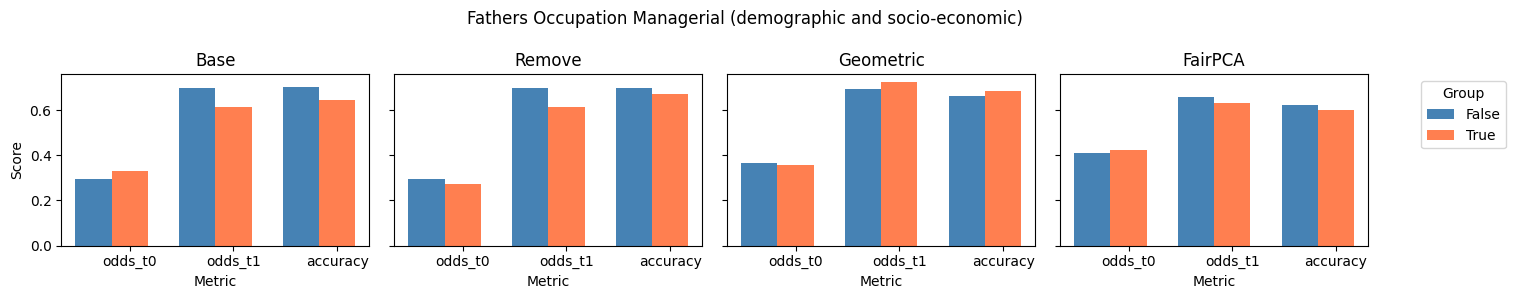

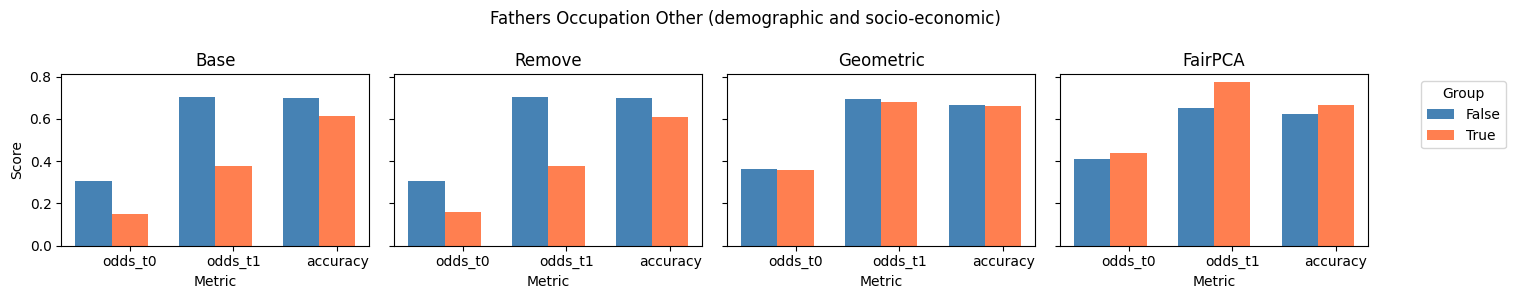

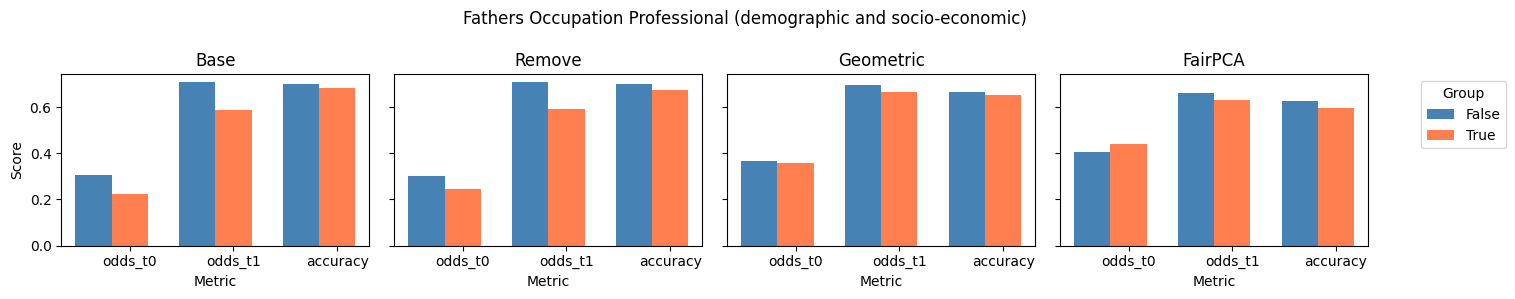

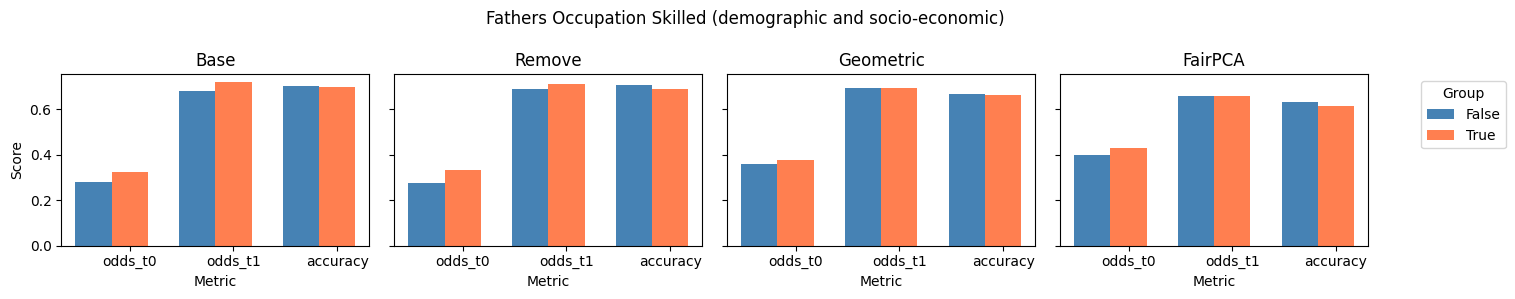

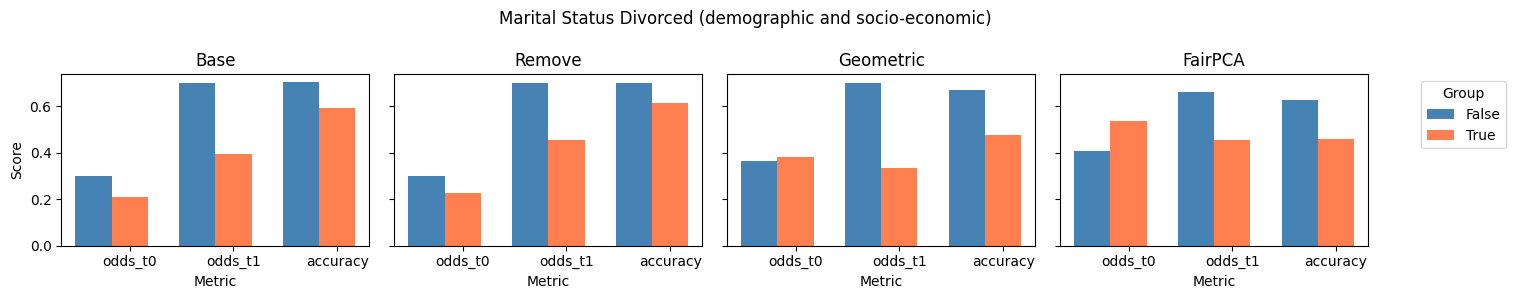

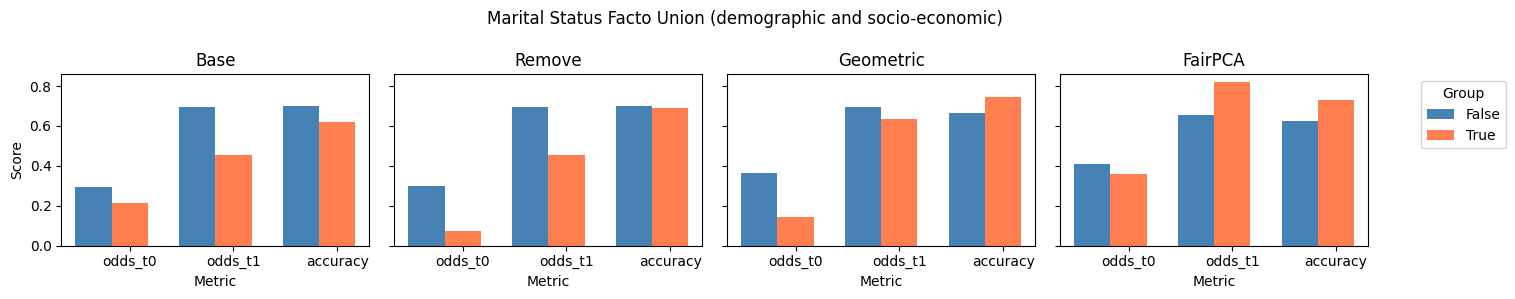

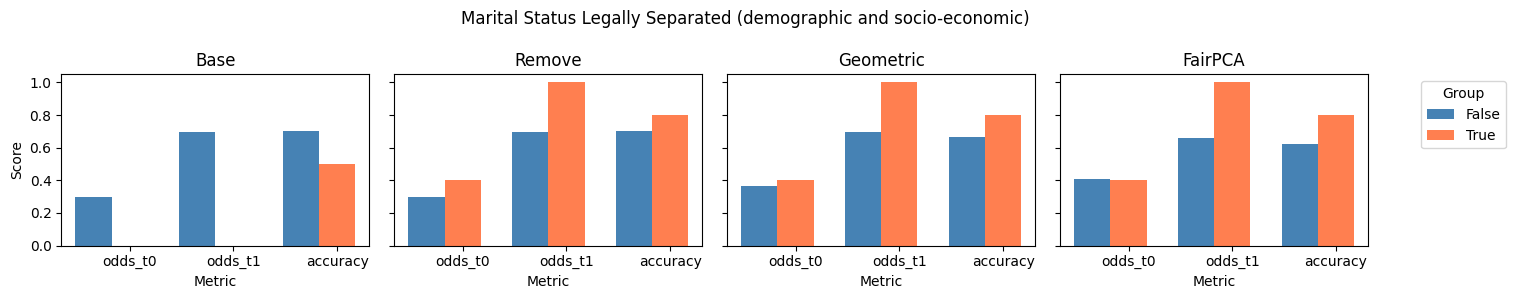

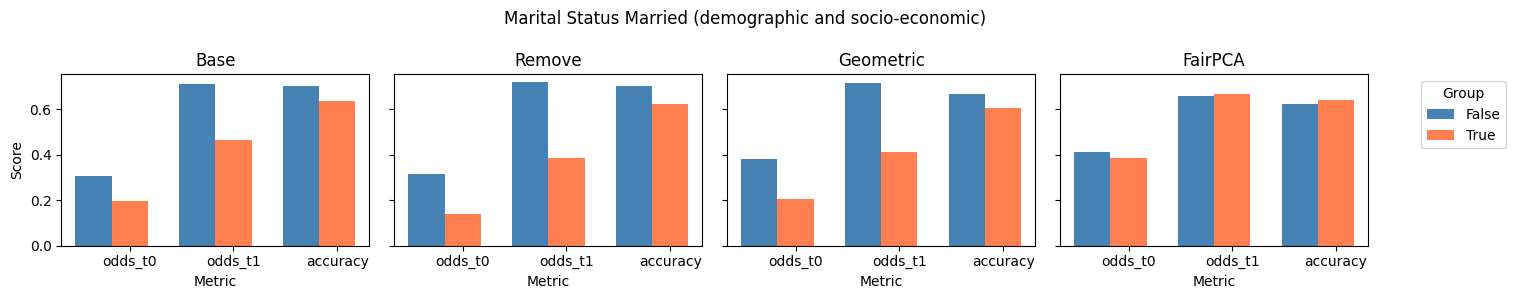

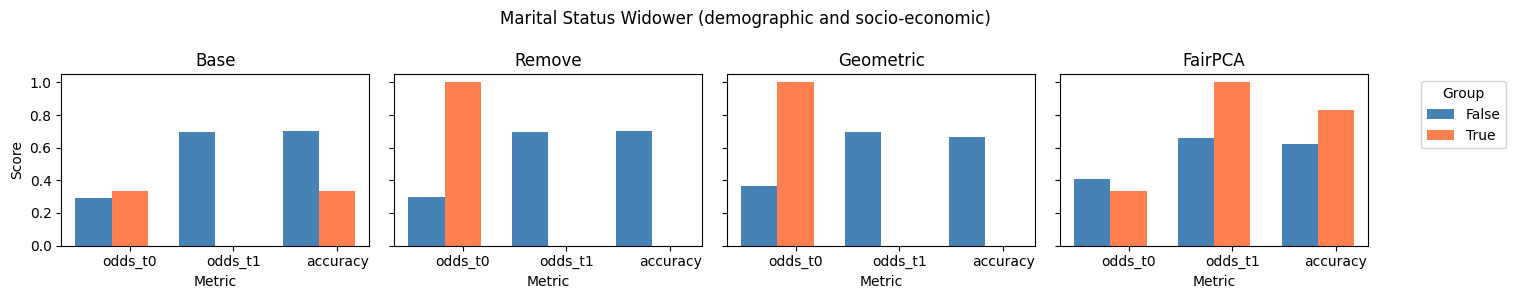

In [24]:
### Remove Demographic and Socio Economic
for g in groups_demographic_and_socio_economic:
    if g=='gender':
        gn = ['Female', 'Male']
    else:
        gn = ['False', 'True']

    log_metric_score = metric_scores(y_test=labels, y_pred = logreg_preds, group_test=groups_demographic_and_socio_economic[g])
    log_metric_df = metric_df(log_metric_score, group_names=gn, names=metric_names)

    log_metric_score_geom_demographic_and_socio_economic = metric_scores(y_test=labels, y_pred = logreg_preds_db_demographic_and_socio_economic, group_test=groups_demographic_and_socio_economic[g])
    log_metric_df_geom_demographic_and_socio_economic = metric_df(log_metric_score_geom_demographic_and_socio_economic, group_names=gn, names=metric_names)

    log_metric_score_pca_demographic_socio_economic = metric_scores(y_test=labels, y_pred = logreg_preds_pca_demographic_and_socio_economic, group_test=groups_demographic_and_socio_economic[g])
    log_metric_df_pca_demographic_and_socio_economic = metric_df(log_metric_score_pca_demographic_socio_economic, group_names=gn, names=metric_names)

    log_metric_score_2 = metric_scores(y_test=labels, y_pred = logreg_preds_unres, group_test=groups_demographic_and_socio_economic[g])
    log_metric_df_2 = metric_df(log_metric_score_2, group_names=gn, names=metric_names)


    plot_scores_and_group_compare([log_metric_df, log_metric_df_2, log_metric_df_geom_demographic_and_socio_economic, log_metric_df_pca_demographic_and_socio_economic], 
                                  titles=['Base', 'Remove', 'Geometric', 'FairPCA'],
                                  suptitle=f'{g.replace("_", " ").title()} (demographic and socio-economic)', 
                                  color_palette=['steelblue', 'coral'], 
                                  figsize=(15,3))

## Investigate the fairPCA model
with demographic and socio-economic features debias

Principle components are difficult as the components are no longer 'real' things, but some combination of features, and this makes it difficult to understand what the model has learnt

In [25]:
groups = features[group_cols_demographic_and_socio_economic]

## the model returned from this function is the last one fitted which is the one trained on fairpca components. Care should be taken if this is changed!

[weights_origin_data_demographic_and_socio_economic, weights_np_demographic_and_socio_economic, _], pca, model = feature_weights(features=features, protected_cols=group_cols_demographic_and_socio_economic, labels=labels,
                                                                                                            model=LogisticRegression(max_iter=1000,  random_state=seed), top_n=len(features))       

In [26]:
model.score(features@pca.U, labels)

0.6322332730560579

In [27]:
# following idea from example paper3:
## U * (s * sign(w))

pca_features = features @ pca.U #Project features into fairPCA space

coefs = model.coef_[0] #get model coefs

signs = [1 if x >=0 else -1 for x in coefs] #sign(w)

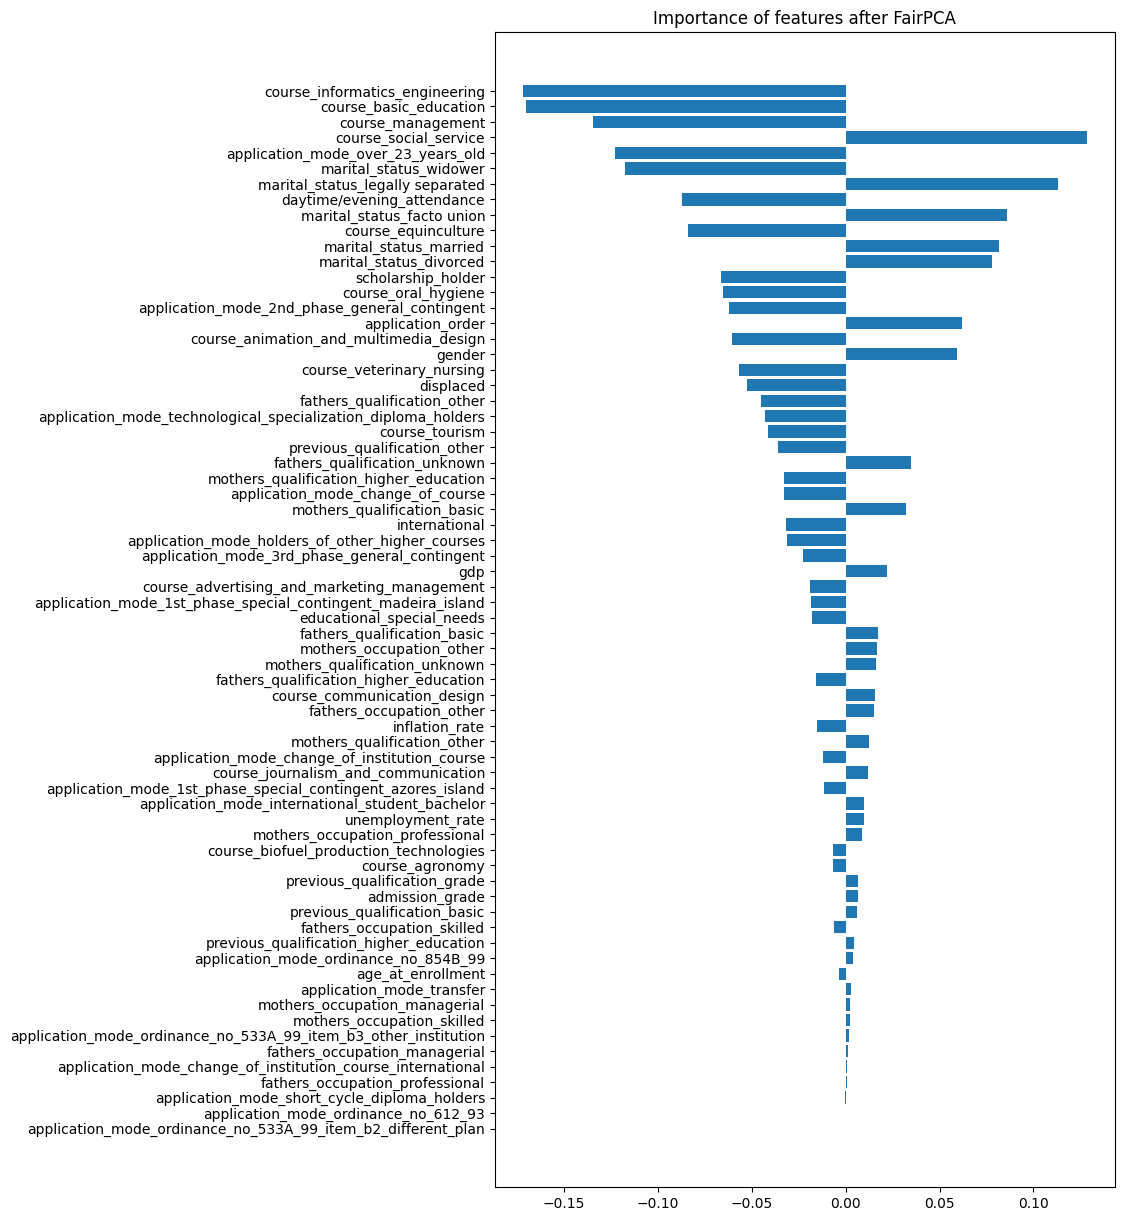

In [28]:
explainer_pca = shap.Explainer(model, pca_features, feature_names=features.columns)
shap_values_pca = explainer_pca(pca_features)

mean_abs_shap_values = abs(shap_values_pca.values).mean(axis=0) #s

# U * (s * sign(w))
importances = (pca.U * (mean_abs_shap_values * signs)).sum(axis=1)

hope = pd.DataFrame([[x[0], x[1] ]for x in zip(importances, features.columns)])

hope.columns = ['influence', 'feature_name']

hope = hope.sort_values(by='influence', key=lambda x: abs(x))

_, ax = plt.subplots(1,1, figsize=(8, 15))
ax.barh(hope.feature_name, hope.influence)
ax.set_title('Importance of features after FairPCA')

plt.savefig('img/pca_explainer.png', transparent=True);

In [29]:
#We can keep this student to test our models on
example = pd.DataFrame(features[(features.course_social_service==1)&(labels.graduated==1)].iloc[0]).T #student from social service course who graduated

counter = example.copy()
print(f'Student will {"graduate" if model.predict(counter@pca.U) == 1 else "not graduate"}') #currently predicts will graduate

##switch counter-factual to a different course, suggested to have a negative affect:
# a student is enrolled on one and only one course, so we should change one course to another, rather than just toggling the binary for enrollment to a specific course

counter.course_informatics_engineering, counter.course_social_service = counter.course_social_service,counter.course_informatics_engineering


print(f'Student will {"graduate" if model.predict(counter@pca.U) == 1 else "not graduate"}') #now they are predicted not to

Student will graduate
Student will not graduate


In [30]:
counter = example.copy()
print(f'Student will {"graduate" if model.predict(counter@pca.U) == 1 else "not graduate"}') #currently predicts will graduate

counter.gender = abs(counter.gender - 1) #flip gender does not change prediction

print(f'Student will {"graduate" if model.predict(counter@pca.U) == 1 else "not graduate"}') #same

Student will graduate
Student will graduate


In [31]:
# principle component coefs:
weights_np_demographic_and_socio_economic[:10]

coef    odds
29  2.445  11.533
22  1.340   3.817
21  1.071   2.919
18  1.032   2.807
34  0.747   2.110
8   0.655   1.925
25  0.565   1.759
35 -1.244   0.288
31 -1.174   0.309
20 -0.857   0.424

In [32]:
# look at PCA component that has the highest coefficient in the model
# so we can look into its make up:
pca_comp = weights_np_demographic_and_socio_economic.index[0]

comp = list(pca.U[pca_comp])

cols = [x for x in features.columns if x not in group_cols_demographic_and_socio_economic]

pca_1 = [x for x in zip(comp, cols)]

pca_1.sort(reverse=True, key=lambda x: abs(x[0]))

# just the 10 largest contributors, because there are many!
pca_1[:10]

[(-0.8543176808035313, 'course_agronomy'),
 (-0.31045939365903996, 'course_basic_education'),
 (-0.2414711791793048, 'application_mode_transfer'),
 (0.1654119008745323, 'application_mode_over_23_years_old'),
 (0.13596509061447118, 'course_advertising_and_marketing_management'),
 (0.11893766401650327, 'course_animation_and_multimedia_design'),
 (-0.10034882337985991, 'course_biofuel_production_technologies'),
 (-0.09414556691642288, 'course_management'),
 (-0.08855789295967638, 'application_mode_ordinance_no_612_93'),
 (0.0823242698328312, 'application_mode_international_student_bachelor')]

Lambda 0.0 completed
Lambda 0.1 completed
Lambda 0.2 completed
Lambda 0.3 completed
Lambda 0.4 completed
Lambda 0.5 completed
Lambda 0.6 completed
Lambda 0.7 completed
Lambda 0.8 completed
Lambda 0.9 completed
Lambda 1.0 completed


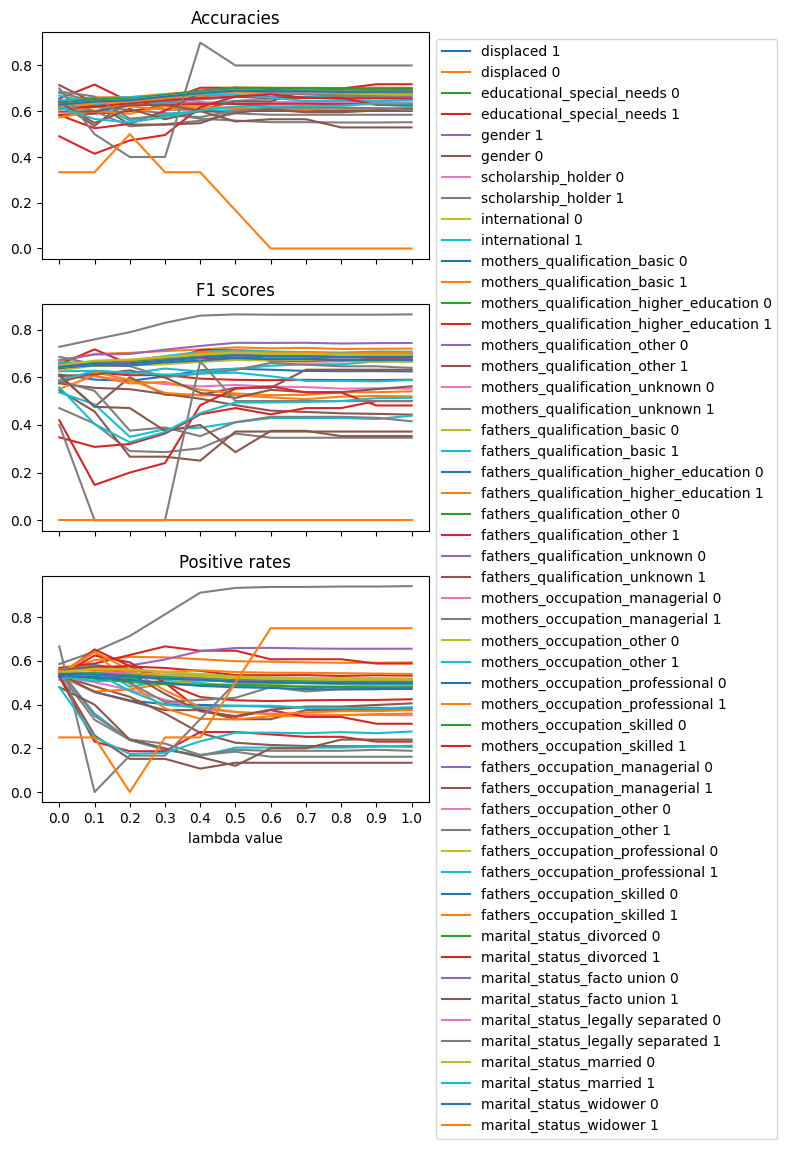

In [33]:
lambda_values, accuracies, f1_scores, positive_rates = tune_lambda(model=LogisticRegression(max_iter=1000, random_state=seed), X=features, y=labels, protected_cols=group_cols_demographic_and_socio_economic, groups=groups)

#this plot has got a little out of hand
plot_tune_lambda(lambda_values, accuracies, f1_scores, positive_rates)

In [34]:
db_df,_ = get_debiased_data(features,features, protected_cols=groups_demographic)
n=db_df.shape[1]+1
db_df = db_df.join(labels)
db_df = db_df.join(features[groups_demographic.columns])


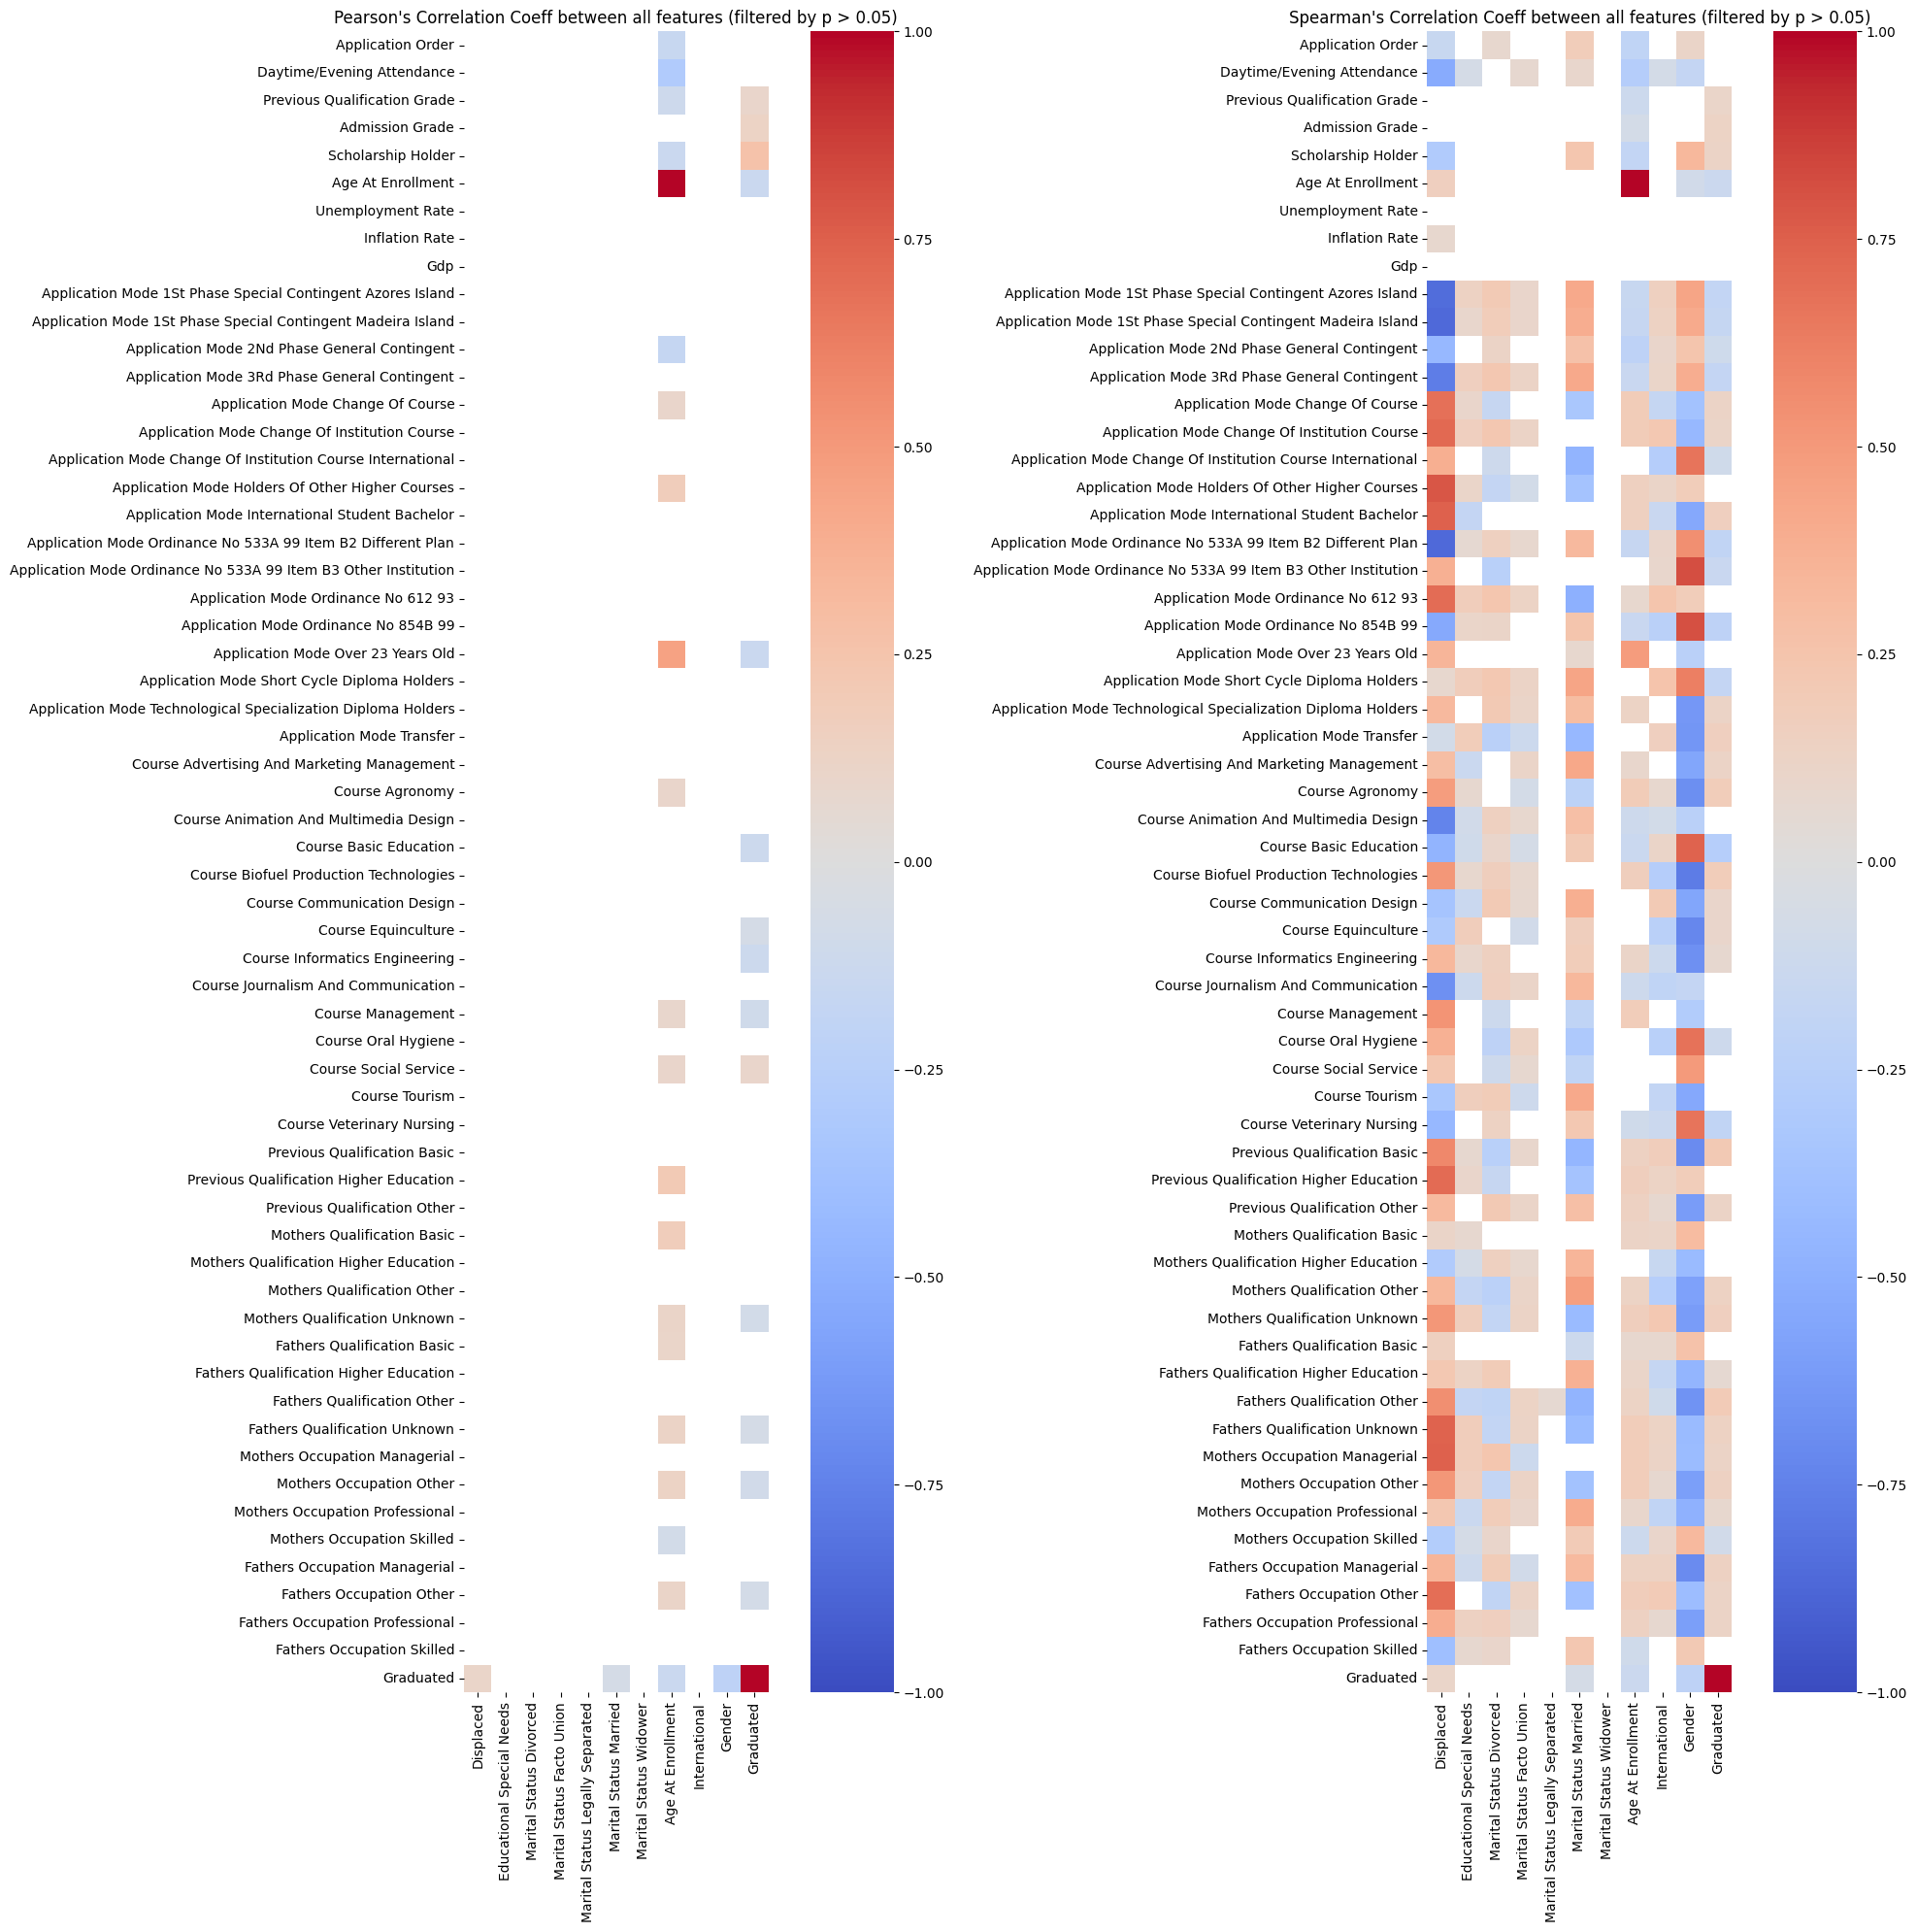

In [35]:
_, ax = plt.subplots(1,2, figsize=(20,20))

plot_corr(df=db_df, feature_cols=protected_cols_demographic + ['graduated'], 
          show_specific_features=True, method='pearson', n=n, ax=ax[0])

plot_corr(df=db_df, feature_cols=protected_cols_demographic + ['graduated'], 
          show_specific_features=True, method='spearman', n=n, ax=ax[1])

plt.savefig('img/side_by_side_geog_debias_corr.png', transparent=True)

In [36]:
pca_df,_, _ = get_pca_data(features,features, protected_cols=groups_demographic)
n=pca_df.shape[1]+1

## To make correlation plots work
pca_df = pca_df.join(labels)
pca_df = pca_df.join(features)

pca_df.columns = [str(x) for x in pca_df.columns]

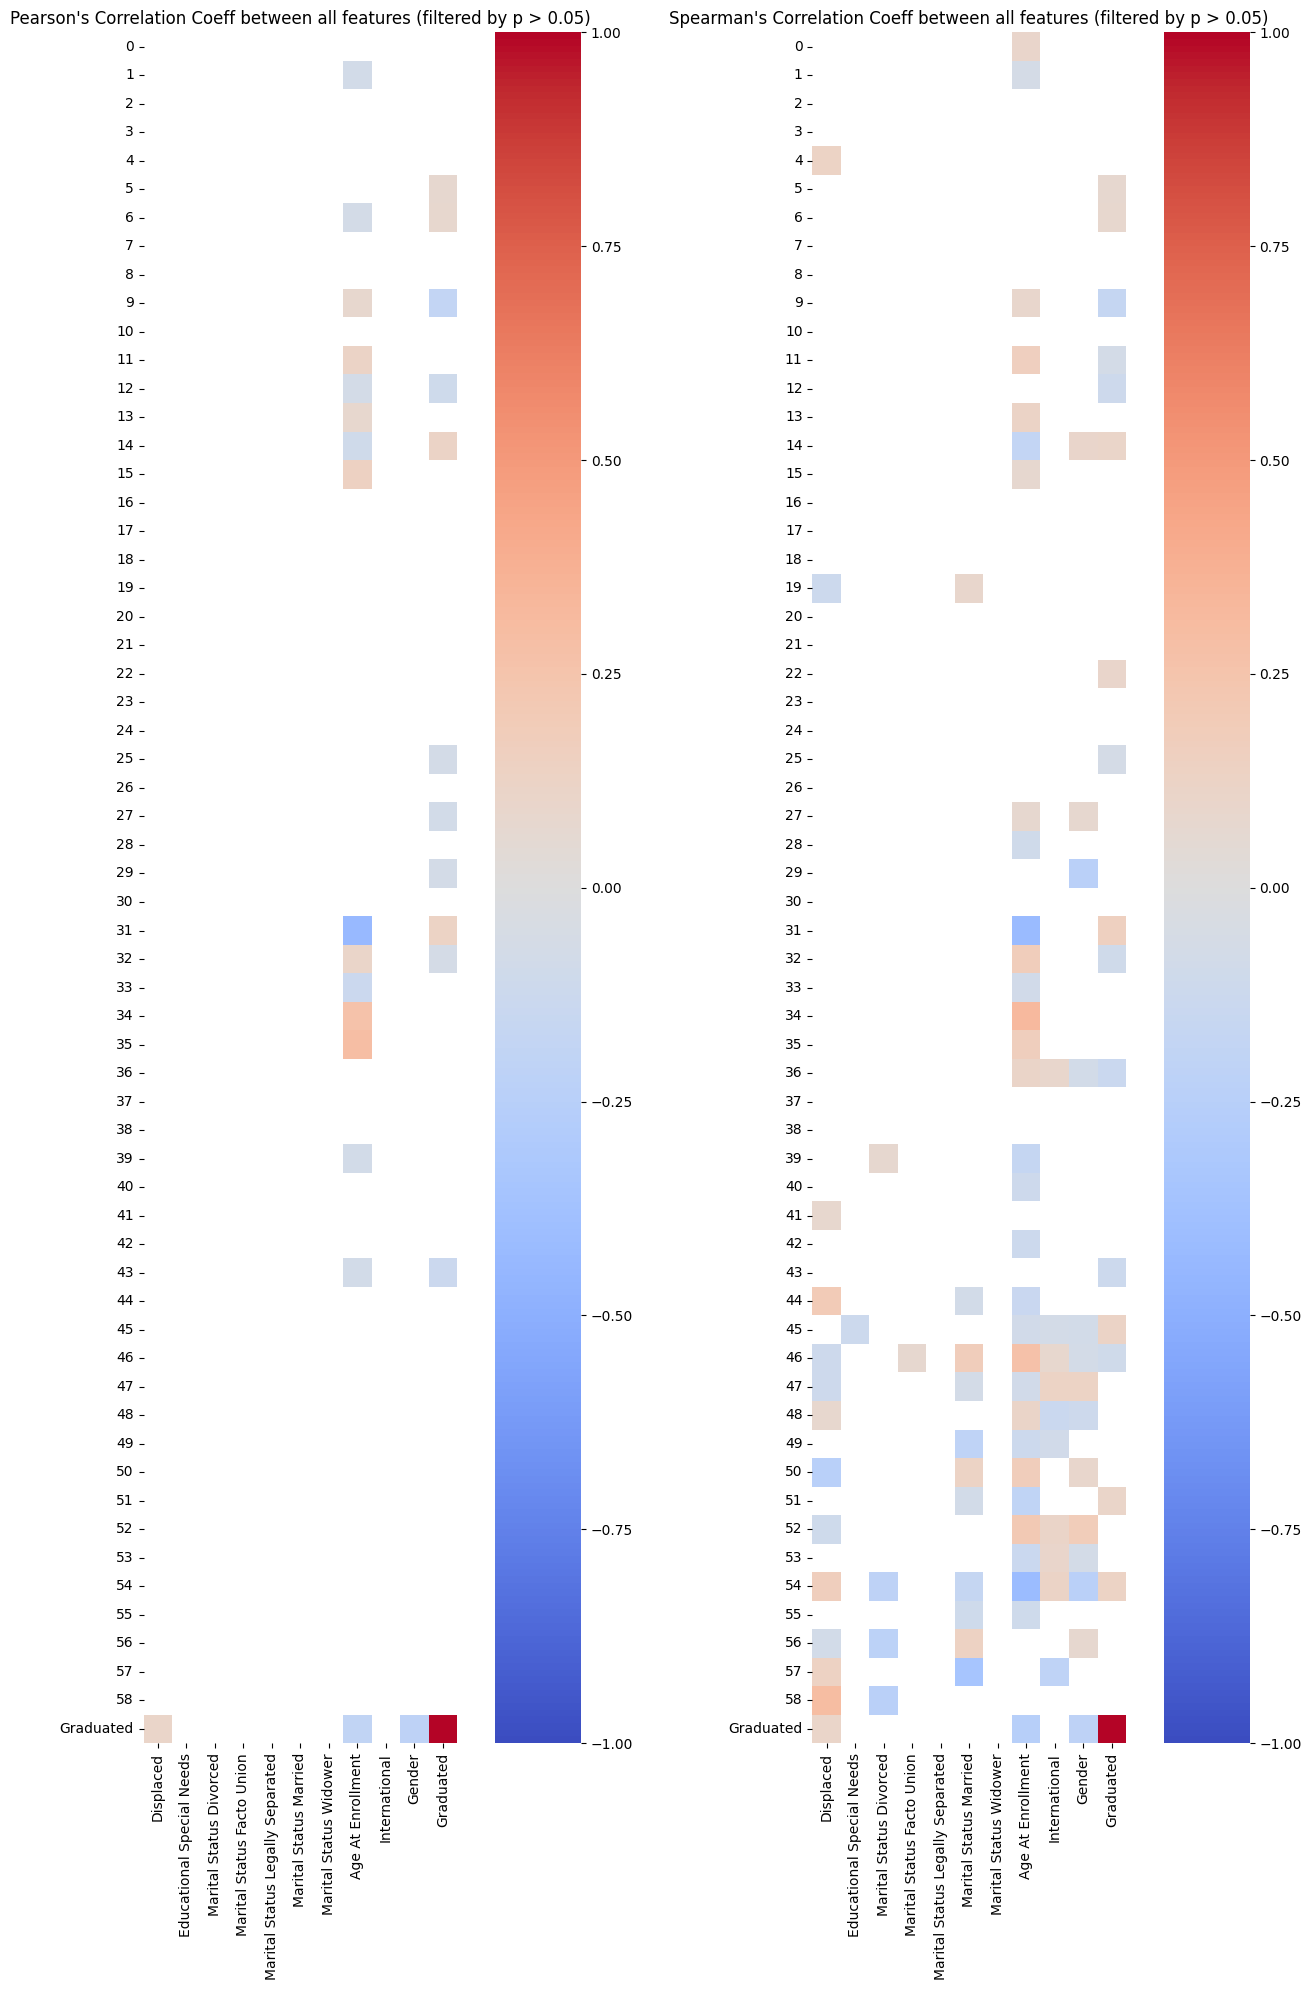

In [37]:
_, ax = plt.subplots(1,2, figsize=(15,20))

plot_corr(df=pca_df, feature_cols=protected_cols_demographic + ['graduated'], 
          show_specific_features=True, method='pearson', n=n, ax=ax[0])

plot_corr(df=pca_df, feature_cols=protected_cols_demographic + ['graduated'], 
          show_specific_features=True, method='spearman', n=n, ax=ax[1])


plt.savefig('img/side_by_side_fairPCA_debias_corr.png', transparent=True)

## Look into shap explainers

In [38]:
# Looking at a basic logreg model, no debiasing/pca etc.
logreg = LogisticRegression(max_iter=1000, random_state=seed)

logreg.fit(features, labels)

feats = list(logreg.feature_names_in_)

In [39]:
counter = example.copy()
print(f'Student will {"graduate" if logreg.predict(counter) == 1 else "not graduate"}') #currently predicts will graduate
counter.gender = abs(counter.gender - 1) #flip gender

print(f'Student will {"graduate" if logreg.predict(counter) == 1 else "not graduate"}') #changing gender changes prediction

Student will graduate
Student will not graduate


In [40]:
explainer_LR = shap.Explainer(logreg, features, feature_names=np.array(feats))

shap_values_LR = explainer_LR(features)

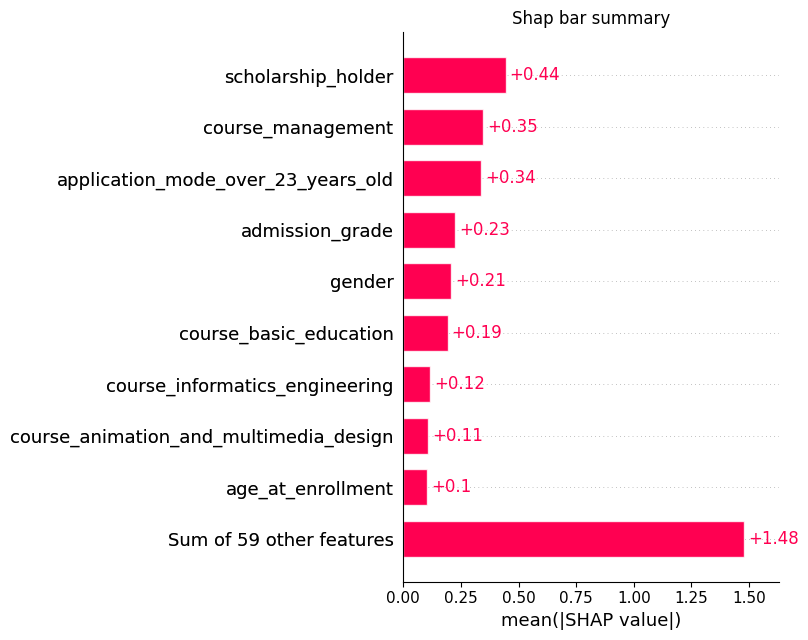

In [41]:
shap.plots.bar(shap_values_LR, max_display=10,show=False)
plt.title(f'Shap bar summary')
plt.tight_layout()

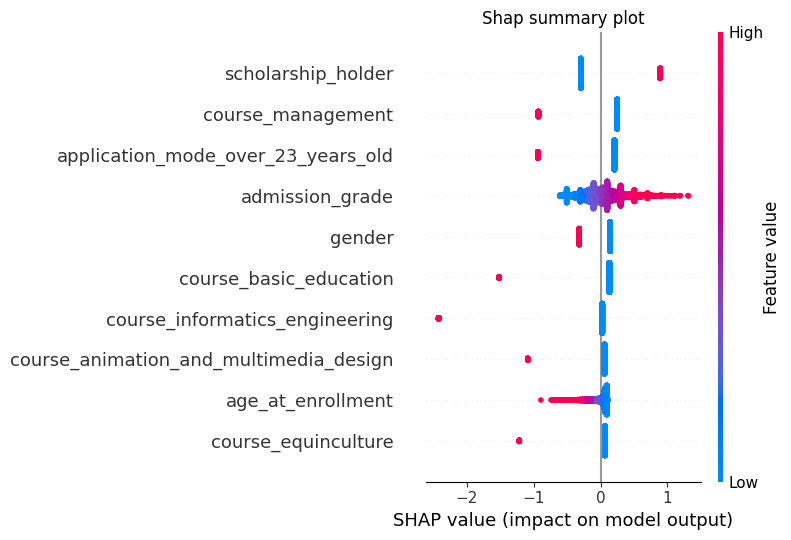

In [42]:
shap.summary_plot(shap_values_LR.values.astype('float64'), 
                  features.astype('float64'), 
                  feature_names=feats, 
                  max_display=10, 
                  show=False)
plt.title(f'Shap summary plot')
plt.tight_layout()
plt.savefig('img/shap_all.png', transparent=True)

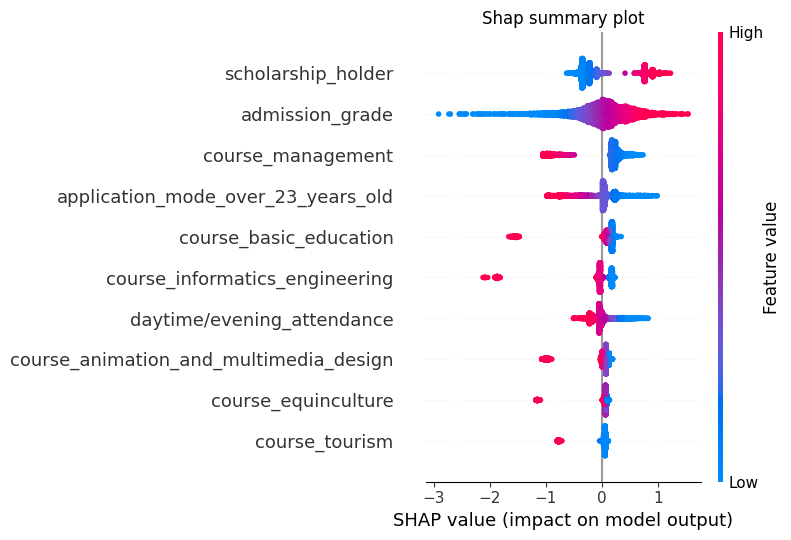

In [43]:
#explainer plot using geometric debiased data
debiased = debias_features(features, protected_cols_demographic)

logreg = LogisticRegression(max_iter=1000, random_state=seed)

logreg.fit(debiased, labels)

feats = list(logreg.feature_names_in_)

explainer_LR = shap.Explainer(logreg, debiased, feature_names=np.array(feats))

shap_values_LR = explainer_LR(debiased)

shap.summary_plot(shap_values_LR.values.astype('float64'), 
                  debiased.astype('float64'), 
                  feature_names=feats, 
                  max_display=10, 
                  show=False)
plt.title(f'Shap summary plot')
plt.tight_layout()
plt.savefig('img/shap_demo.png', transparent=True)

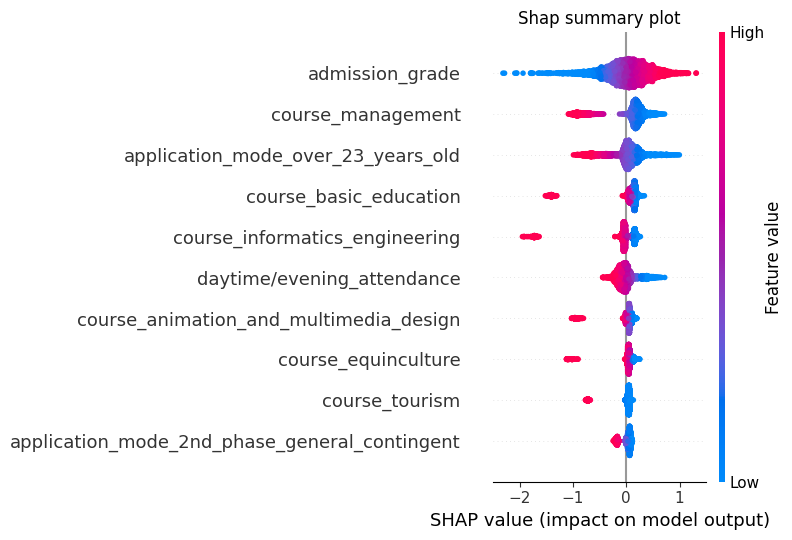

In [44]:
#explainer plot using geometric and socio-economic debiased data

debiased = debias_features(features, protected_cols_demographic_and_socio_economic)

logreg = LogisticRegression(max_iter=1000, random_state=seed)

logreg.fit(debiased, labels)

feats = list(logreg.feature_names_in_)

explainer_LR = shap.Explainer(logreg, debiased, feature_names=np.array(feats))

shap_values_LR = explainer_LR(debiased)

shap.summary_plot(shap_values_LR.values.astype('float64'), 
                  debiased.astype('float64'), 
                  feature_names=feats, 
                  max_display=10, 
                  show=False)
plt.title(f'Shap summary plot')
plt.tight_layout()
plt.savefig('img/shap_demo_socio_ec.png', transparent=True)